In [2]:
import typing as t

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from matplotlib import pyplot as plt

In [3]:
torch.manual_seed(0)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    transform=transform,
    download=True,
    train=True
)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print(idx_to_class)

100%|██████████| 26421880/26421880 [00:01<00:00, 17716077.14it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274202.79it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5029530.25it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25921100.83it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


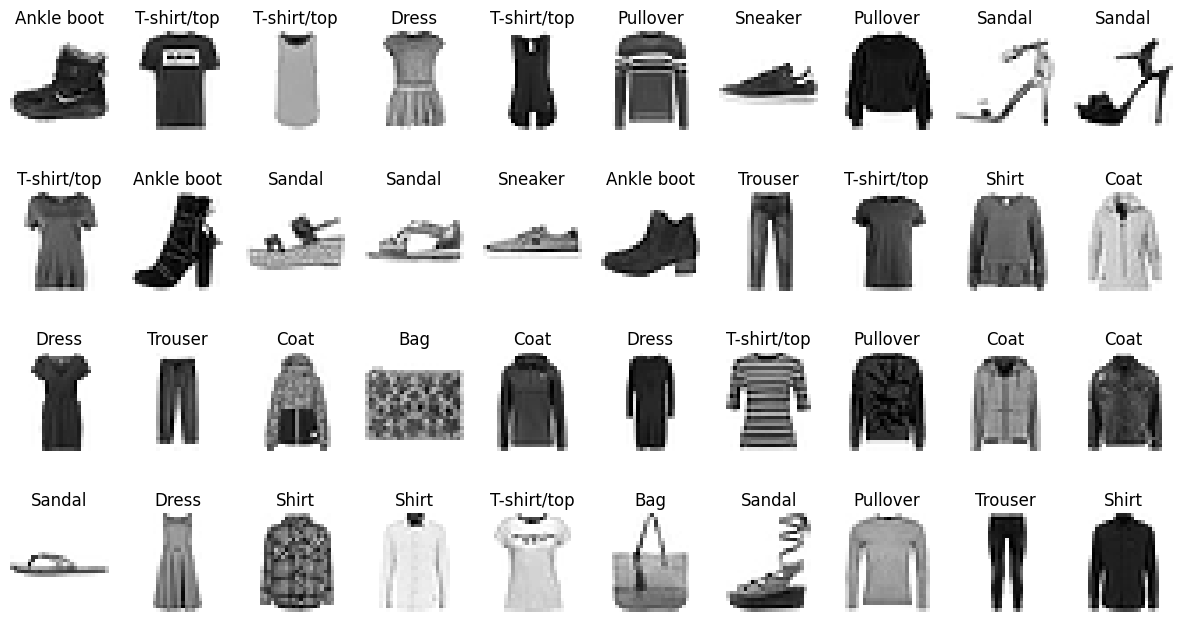

In [4]:
n_rows, n_cols = 4, 10

plot_batch = [dataset[i] for i in range(n_rows * n_cols)]
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(int(n_cols * 1.5), int(n_rows * 2))
)

for i in range(n_rows * n_cols):
  ax_title = idx_to_class[plot_batch[i][1]]
  img_show = plot_batch[i][0].permute(1, 2, 0)
  row_id = i // n_cols
  col_id = i % n_cols
  axes[row_id][col_id].set_title(ax_title)
  axes[row_id][col_id].imshow(img_show, cmap='gray_r')
  axes[row_id][col_id].set_axis_off()

plt.show()

In [5]:
class Discriminator(nn.Module):

  def __init__(self, img_channels: int, feature_dim: int) -> None:
    super().__init__()
    self.backbone = nn.Sequential(
        nn.Conv2d(
            in_channels=img_channels,
            out_channels=feature_dim,
            kernel_size=4,
            stride=1,
            padding=1
        ),
        nn.LeakyReLU(0.2),
        self.building_block(
            in_channels=feature_dim, out_channels=feature_dim * 2,
            kernel_size=4, stride=1, padding=1
        ),
        self.building_block(
            in_channels=feature_dim * 2, out_channels=feature_dim * 4,
            kernel_size=4, stride=2, padding=1
        ),
        self.building_block(
            in_channels=feature_dim * 4, out_channels=feature_dim * 8,
            kernel_size=4, stride=2, padding=1
        ),
        self.building_block(
            in_channels=feature_dim * 8, out_channels=feature_dim * 16,
            kernel_size=4, stride=2, padding=1
        )
    )
    self.detector = nn.Sequential(
        nn.Conv2d(
            in_channels=feature_dim * 16, out_channels=1,
            kernel_size=3, stride=1, padding=0
        ),
        nn.Flatten()
    )

  def building_block(
      self,
      in_channels: int,
      out_channels: int,
      kernel_size: int,
      stride: int,
      padding: int
  ) -> nn.Module:
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        ),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.backbone(x)
    return self.detector(x)


In [6]:
class Generator(nn.Module):

  def __init__(self, noize_channels: int, feature_dim: int, img_channels) -> None:
    super().__init__()
    self.backbone = nn.Sequential(
        self.building_block(
            in_channels=noize_channels, out_channels=feature_dim * 64,
            kernel_size=4, stride=1, padding=0
        ),
        self.building_block(
            in_channels=feature_dim * 64, out_channels=feature_dim * 32,
            kernel_size=4, stride=2, padding=0
        ),
        self.building_block(
            in_channels=feature_dim * 32, out_channels=feature_dim * 16,
            kernel_size=4, stride=2, padding=0
        ),
        self.building_block(
            in_channels=feature_dim * 16, out_channels=feature_dim * 8,
            kernel_size=4, stride=1, padding=0
        )
    )
    self.generator = nn.ConvTranspose2d(
        in_channels=feature_dim * 8,
        out_channels=img_channels,
        kernel_size=4,
        stride=1,
        padding=0
    )

  def building_block(
      self,
      in_channels: int,
      out_channels: int,
      kernel_size: int,
      stride: int,
      padding: int
  ) -> nn.Module:
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        ),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.backbone(x)
    return self.generator(x)

In [7]:
def weight_init(module: nn.Module) -> None:
  if isinstance(module, nn.Conv2d):
    nn.init.normal_(module.weight.data, mean=0, std=0.02)
  if isinstance(module, nn.BatchNorm2d):
    nn.init.normal_(module.weight.data, mean=0, std=0.02)
    nn.init.constant_(module.weight.data, val=0)

In [8]:
def gradient_penalty(
    d_model: nn.Module,
    fake_images: torch.Tensor,
    real_images: torch.Tensor,
    device: str
) -> torch.Tensor:

  batch_size, c, w, h = real_images.shape
  alphas = torch.rand((batch_size, 1, 1, 1)).repeat((1, c, w, h)).to(device)
  interpolate_images = alphas * real_images + (1 - alphas) * fake_images
  scores = d_model(interpolate_images)

  gradient = torch.autograd.grad(
      outputs=scores,
      inputs=interpolate_images,
      grad_outputs=torch.ones_like(scores),
      create_graph=True,
      retain_graph=True
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  g_norm = gradient.norm(p=2, dim=1)
  penalty = torch.mean((g_norm - 1) ** 2)
  return penalty

In [9]:
def add_label_to_image(image: torch.Tensor, n_labels: int, label: int) -> torch.Tensor:
  _, w, h = image.shape
  label_channels = torch.zeros((n_labels, w, h))
  label_channels[label, :, :] = 1
  return torch.cat((image, label_channels), dim=0)

In [10]:
channels_dataset = [
    tuple([
        add_label_to_image(
            image=dataset[i][0],
            n_labels=len(idx_to_class),
            label=dataset[i][1]
        ),
        dataset[i][1]
    ])
    for i in range(len(dataset))
]

In [14]:
def plot_generator(
    g_model: nn.Module,
    gen_dim: int,
    img_channels: int,
    idx_to_class: t.Dict[int, str],
    n_labels: int,
    device: str,
    n_cols: int = 10
) -> None:
  noize = torch.randn((n_labels, gen_dim, 1, 1))
  labels = torch.zeros((n_labels, n_labels, 1, 1))
  for i in range(n_labels):
    labels[i, i, :, :] = 1
  noize_and_label = torch.cat((noize, labels), dim=1).to(device)

  with torch.no_grad():
    gen_images = g_model(noize_and_label).detach().cpu()

  n_rows = n_labels // n_cols + 1
  fig, axes = plt.subplots(
      n_rows, n_cols,
      figsize=(int(n_cols * 1.5), int(n_rows * 2))
  )

  for i in range(n_cols * n_rows):
    row_id = i // n_cols
    col_id = i % n_cols

    if i < n_labels:
      axes[row_id][col_id].set_title(idx_to_class[i])
      axes[row_id][col_id].imshow(
          gen_images[i, 0:img_channels, :, :].permute(1, 2, 0),
          cmap='gray_r'
      )
    axes[row_id][col_id].set_axis_off()

  plt.show()

In [15]:
def train_batch(
    d_model: nn.Module,
    g_model: nn.Module,
    d_optimizer: torch.optim.Optimizer,
    g_optimizer: torch.optim.Optimizer,
    real_batch: t.Tuple,
    gen_dim: int,
    n_labels: int,
    device: str
) -> t.Tuple[float, float]:
  batch_size = real_batch[0].shape[0]

  # D_model step
  noize = torch.randn((batch_size, gen_dim, 1, 1))
  labels = torch.zeros((batch_size, n_labels))
  real_labels = real_batch[1]
  labels[torch.arange(batch_size), real_labels] = 1
  labels = labels.unsqueeze(-1).unsqueeze(-1)

  noize_and_label = torch.cat((noize, labels), dim=1).to(device)
  gen_images = g_model(noize_and_label)
  labels = labels.repeat(1, 1, gen_images.shape[2], gen_images.shape[3])
  labels = labels.to(device)
  gen_images = torch.cat((gen_images, labels), dim=1)
  real_images = real_batch[0].to(device)

  d_score_real = d_model(real_images)
  d_score_gen = d_model(gen_images)
  grad_penalty = gradient_penalty(d_model, gen_images, real_images, device=device)

  d_loss = torch.mean(d_score_gen) - torch.mean(d_score_real) + 10 * grad_penalty
  d_optimizer.zero_grad()
  d_loss.backward(retain_graph=True)
  d_optimizer.step()

  # G_model step
  gen_score = d_model(gen_images).reshape(-1)
  g_loss = -torch.mean(gen_score)
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()

  return d_loss.detach().cpu().item(), g_loss.detach().cpu().item()

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_epochs = 100
n_labels = 10
noize_dim = 100
img_channels = 1
learning_rate = 1e-4
train_loader = torch.utils.data.DataLoader(channels_dataset, batch_size=32, shuffle=True)

d_model = Discriminator(img_channels=1 + n_labels, feature_dim=4).to(device)
g_model = Generator(noize_channels=noize_dim + n_labels, img_channels=1, feature_dim=4).to(device)

d_optimizer = torch.optim.Adam(d_model.parameters(), lr=learning_rate, betas=(0., 0.9))
g_optimizer = torch.optim.Adam(g_model.parameters(), lr=learning_rate, betas=(0., 0.9))

Epoch: 0, Losses: -0.07334440631866455, -2.664950914637248


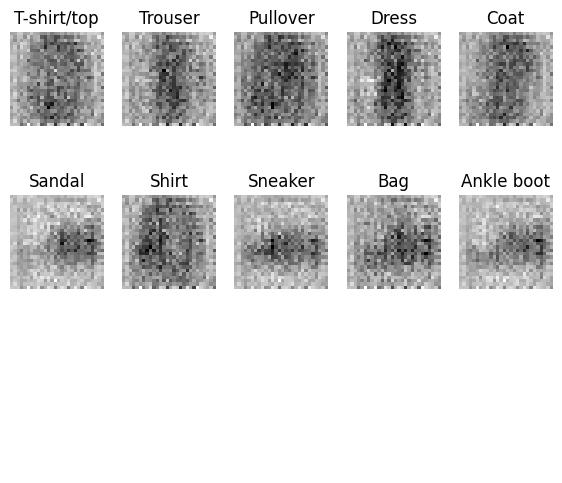

Epoch: 1, Losses: -1.5631969688097636, -4.290969145711263


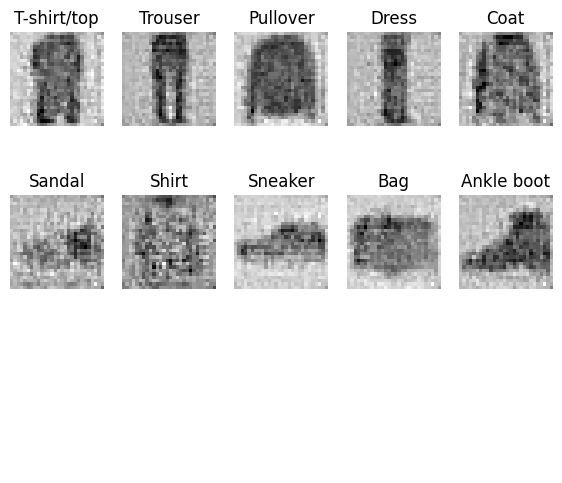

Epoch: 2, Losses: -0.6298615585803986, -5.595959219868978


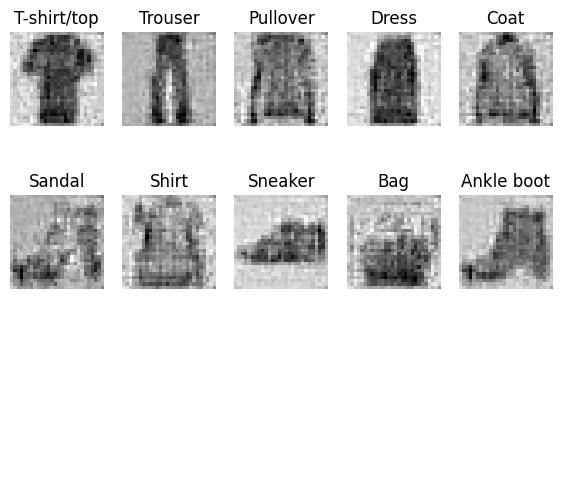

Epoch: 3, Losses: -0.4910775073170662, -5.537002430979411


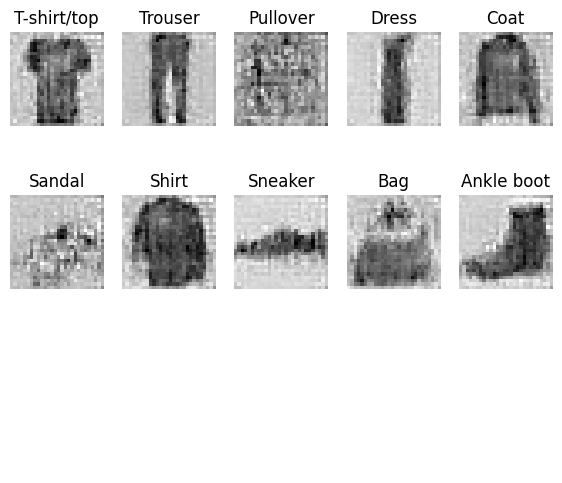

Epoch: 4, Losses: -0.4212832282384237, -5.256138776652018


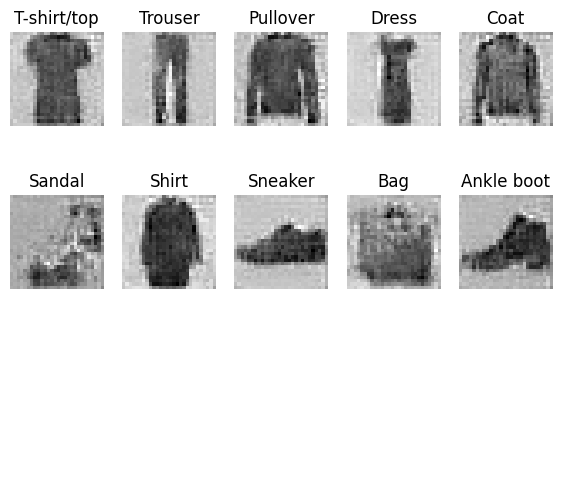

Epoch: 5, Losses: -0.3686701806982358, -5.102512861378988


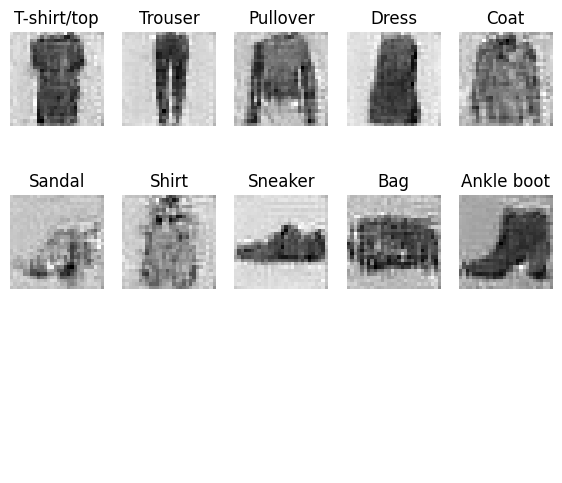

Epoch: 6, Losses: -0.33426911253929137, -5.126197211074829


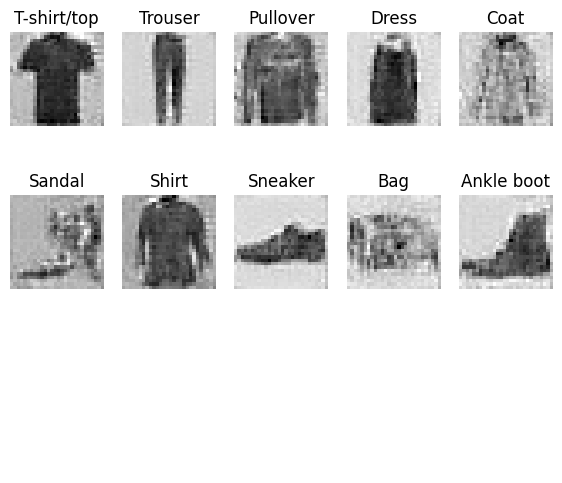

Epoch: 7, Losses: -0.30623231016000113, -5.244121171061198


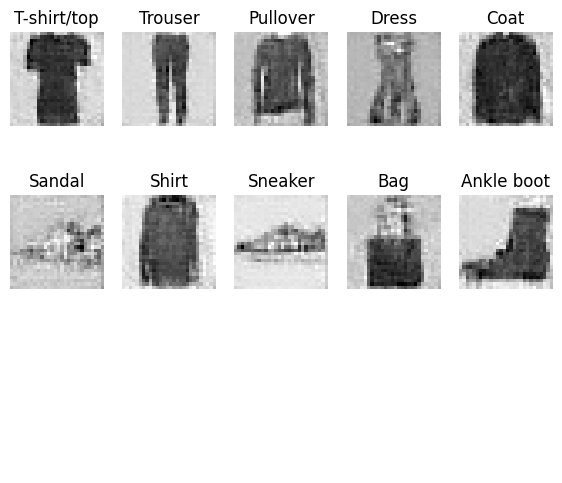

Epoch: 8, Losses: -0.2799970709661643, -5.504124292755127


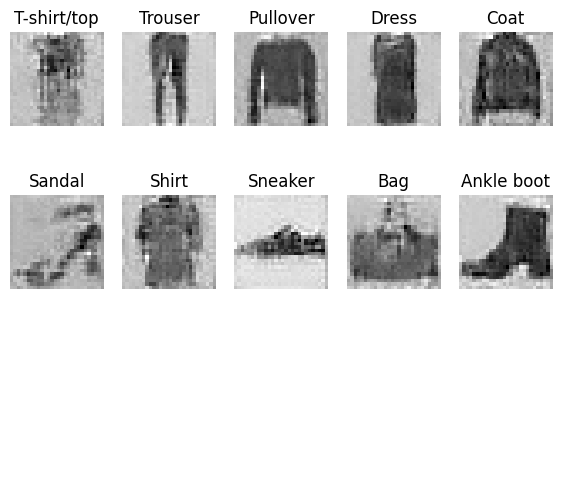

Epoch: 9, Losses: -0.2707500220576922, -5.625581812032064


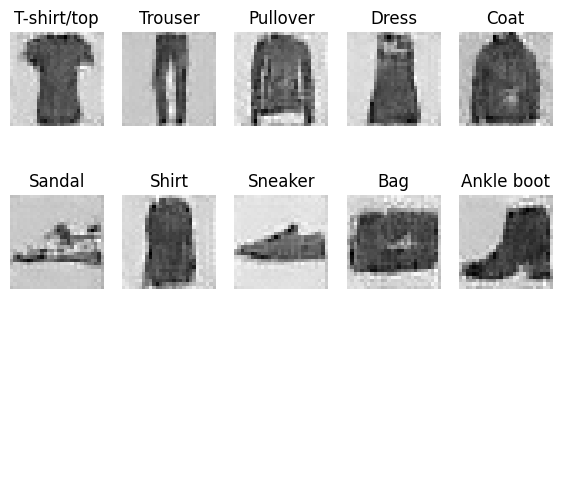

Epoch: 10, Losses: -0.26992275392015774, -5.804670267486572


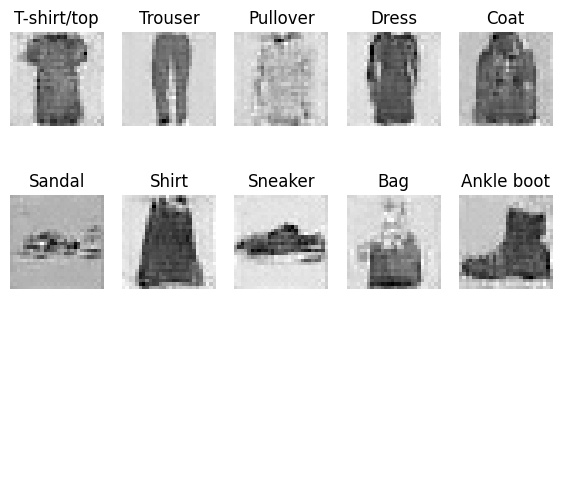

Epoch: 11, Losses: -0.2460390985409419, -5.835791682688395


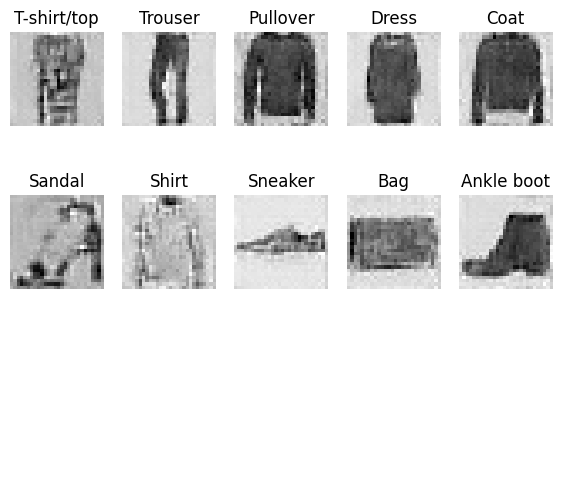

Epoch: 12, Losses: -0.22943860240976016, -6.1482884862264


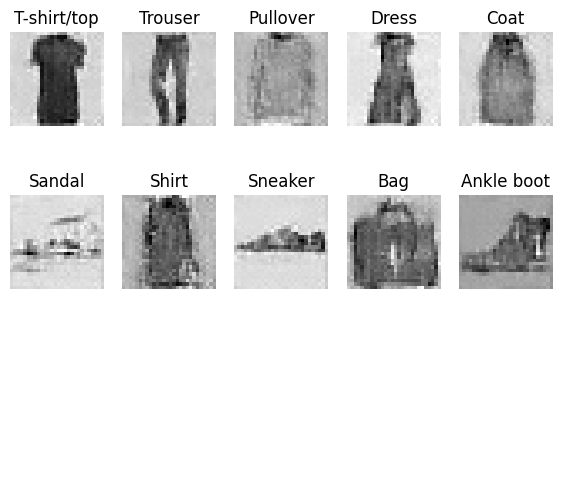

Epoch: 13, Losses: -0.2144827365040779, -6.225037067667643


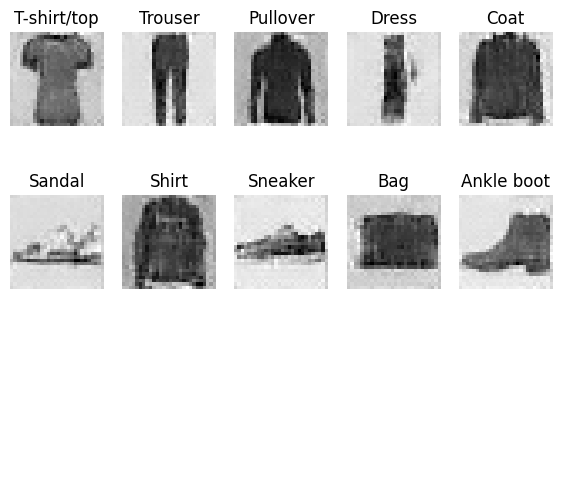

Epoch: 14, Losses: -0.20475815674364567, -6.424948755900065


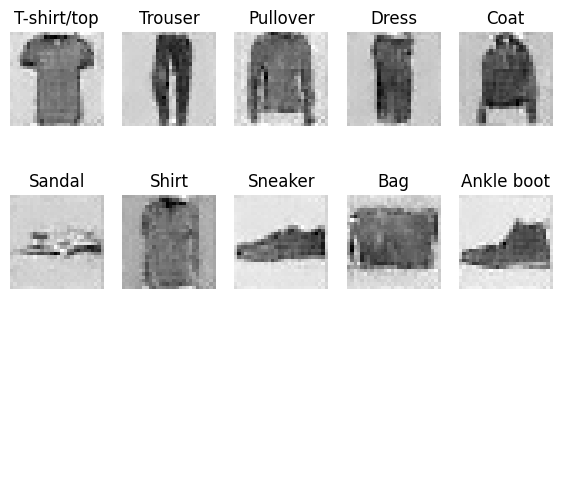

Epoch: 15, Losses: -0.18991567060550055, -6.6314819674173995


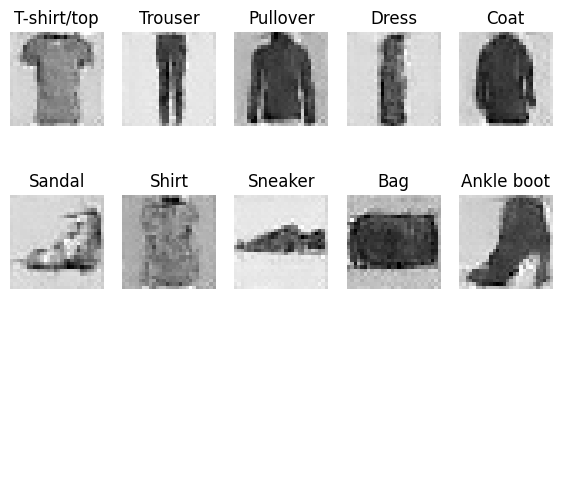

Epoch: 16, Losses: -0.17067613010207813, -6.486887140655518


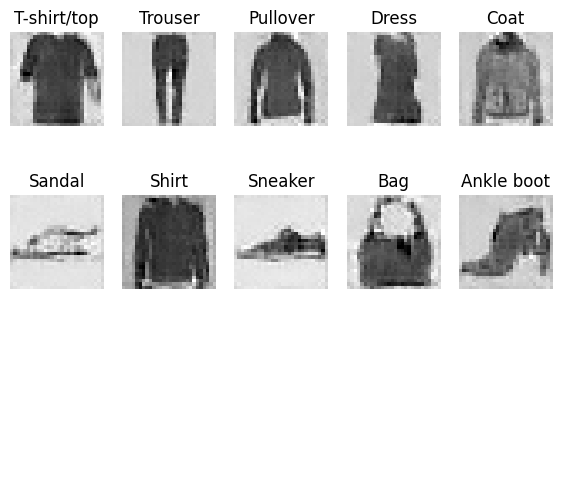

Epoch: 17, Losses: -0.15360060046613216, -6.312664084625244


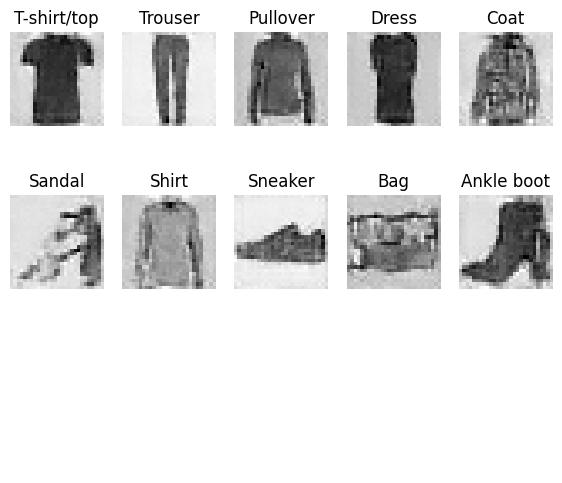

Epoch: 18, Losses: -0.13800466617147128, -6.157481730143229


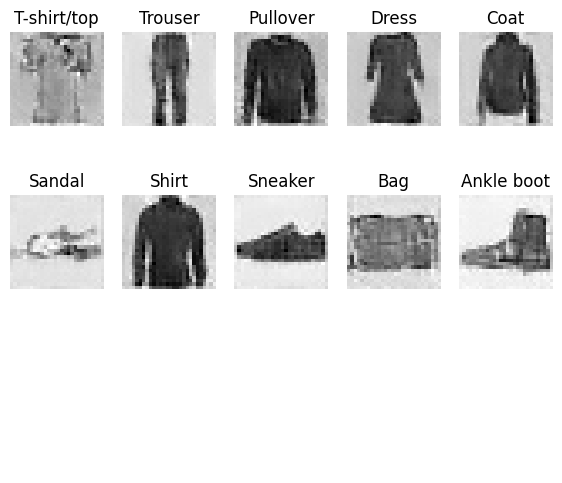

Epoch: 19, Losses: -0.12375676323473453, -6.187075864664713


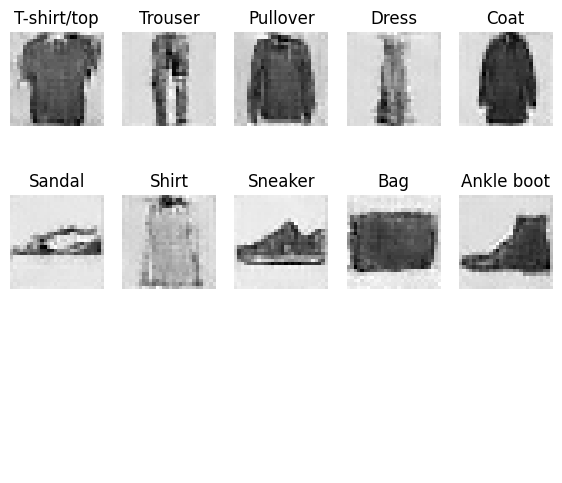

Epoch: 20, Losses: -0.11383976521293322, -6.257224325815836


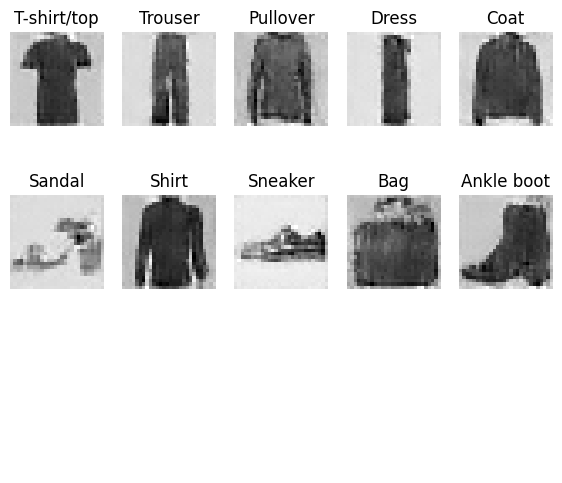

Epoch: 21, Losses: -0.10549811500807603, -6.351627941385905


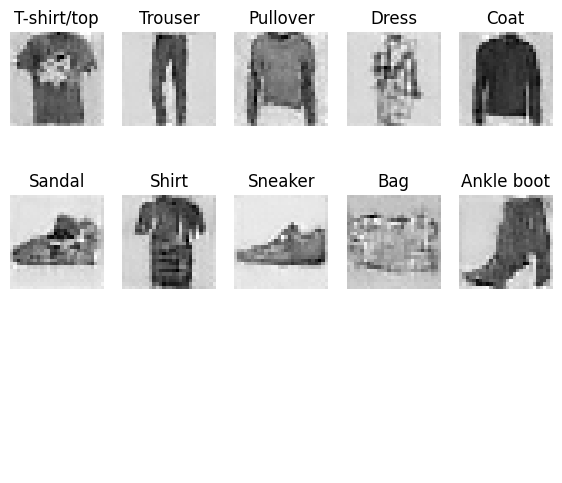

Epoch: 22, Losses: -0.09694321360985438, -6.242704014078776


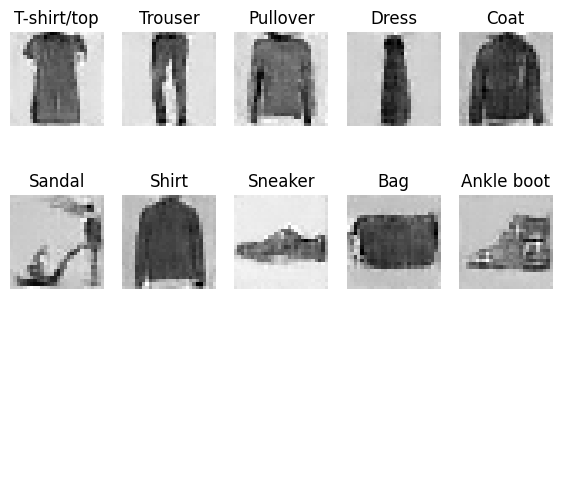

Epoch: 23, Losses: -0.08789341618021329, -6.374854082743327


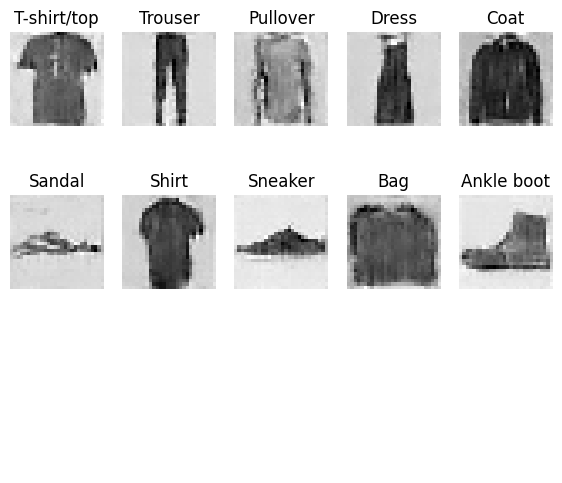

Epoch: 24, Losses: -0.07988954693774382, -6.430680671183268


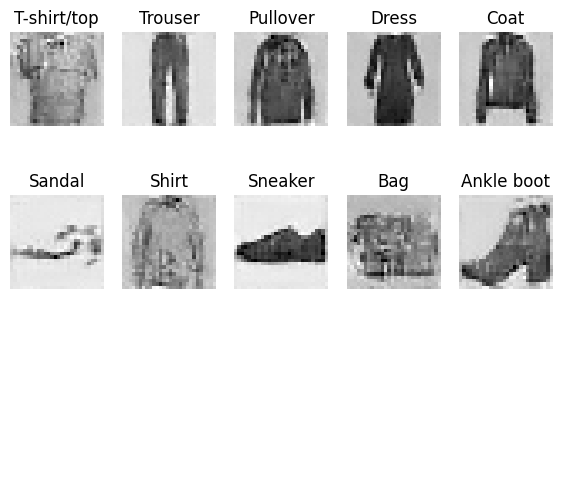

Epoch: 25, Losses: -0.06299599475959937, -6.486870866902669


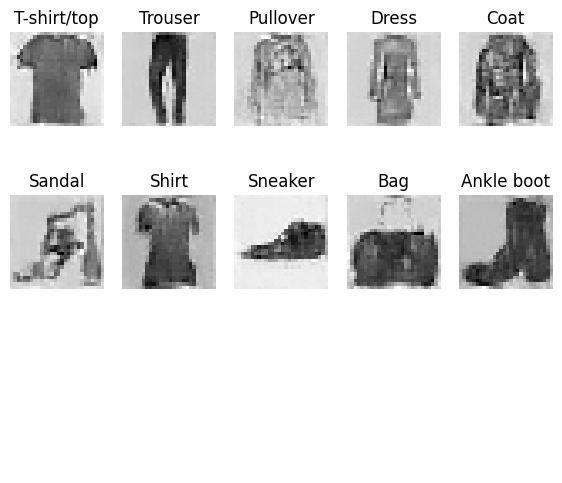

Epoch: 26, Losses: -0.05602542245090008, -6.377563264465332


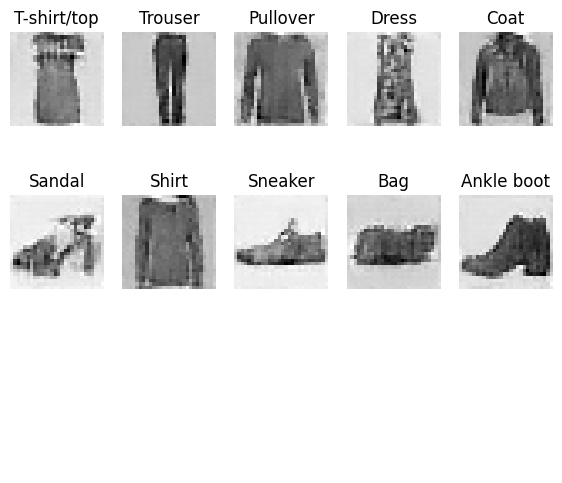

Epoch: 27, Losses: -0.05074905811945597, -6.424357848612467


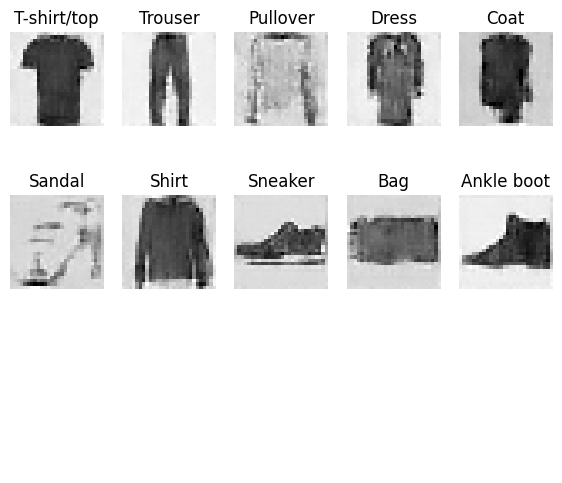

Epoch: 28, Losses: -0.039811749466260274, -6.433025498199463


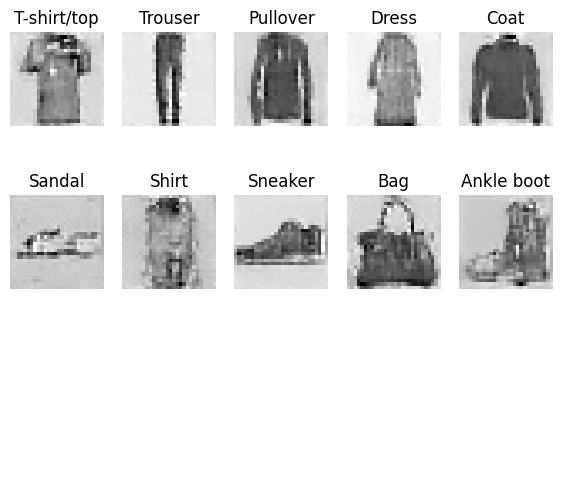

Epoch: 29, Losses: -0.036830922614534696, -6.4518951873779296


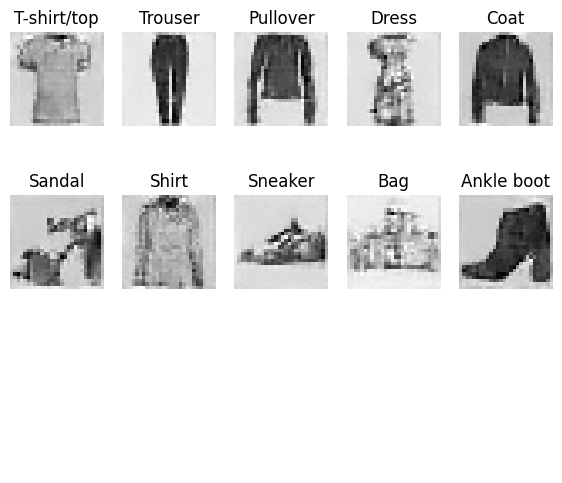

Epoch: 30, Losses: -0.02945993217031161, -6.488232043202718


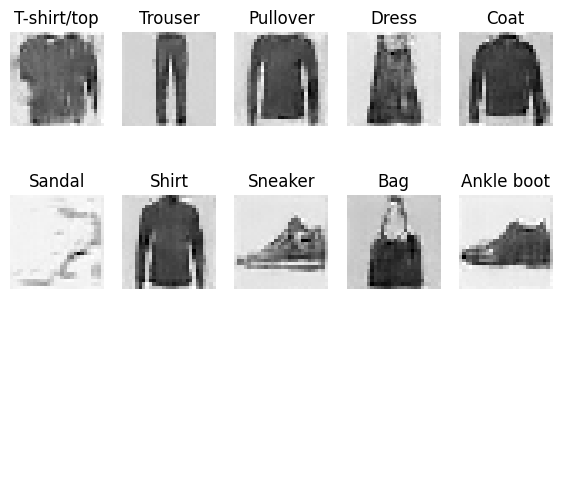

Epoch: 31, Losses: -0.02887914048731327, -6.361272348531087


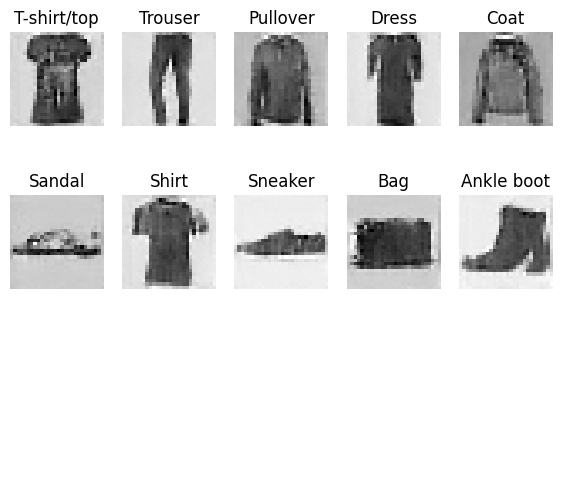

Epoch: 32, Losses: -0.023496027779579164, -6.509111503092448


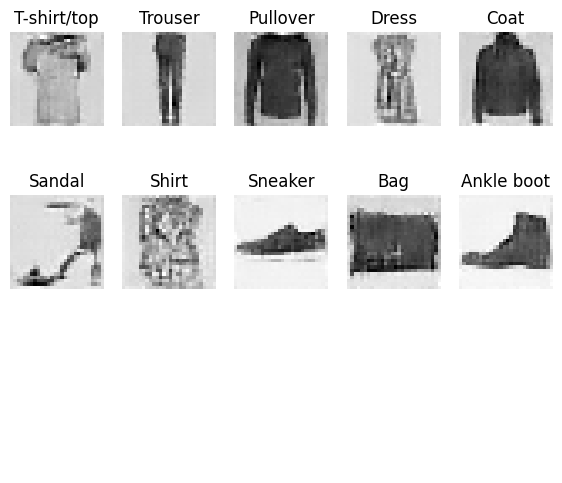

Epoch: 33, Losses: -0.024192693511645, -6.513331187438965


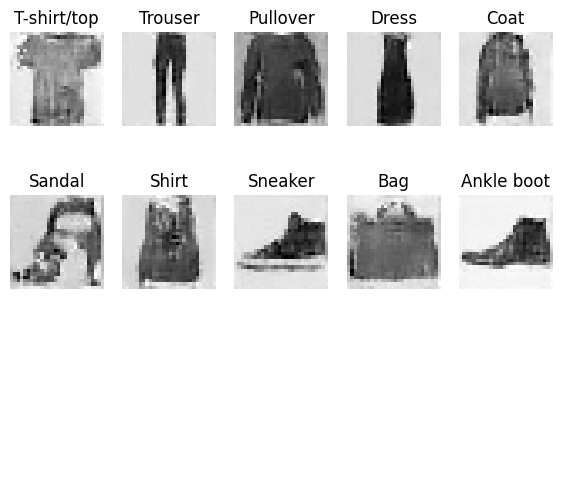

Epoch: 34, Losses: -0.024809446342786153, -6.505828356170654


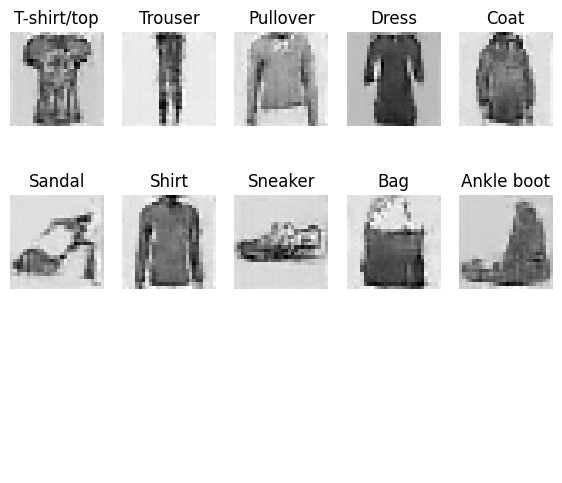

Epoch: 35, Losses: -0.021140386472145715, -6.314586382548014


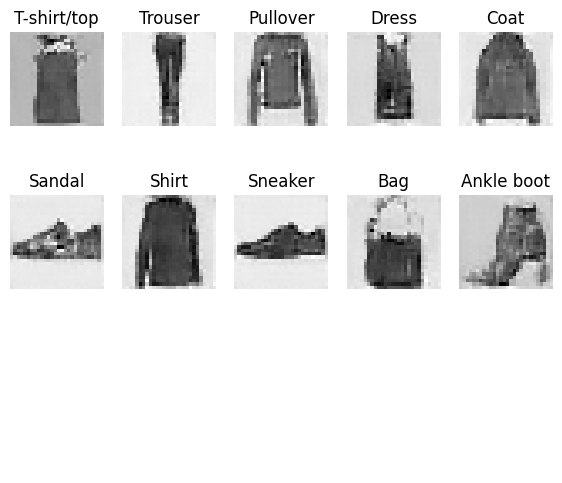

Epoch: 36, Losses: -0.02150829273959001, -6.2320311182657875


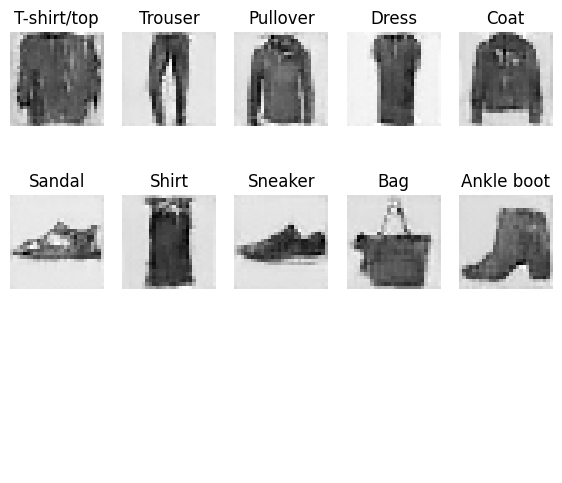

Epoch: 37, Losses: -0.013812295990188916, -6.336659737650553


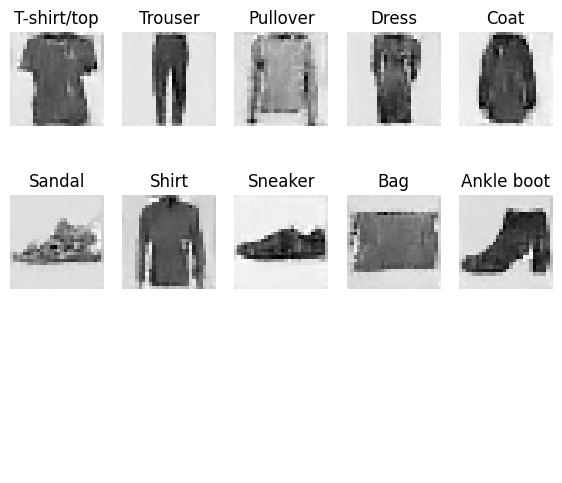

Epoch: 38, Losses: -0.012090095060070355, -6.203542416127523


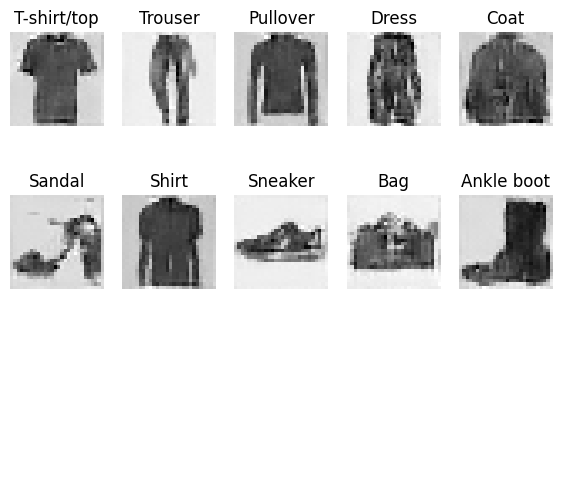

Epoch: 39, Losses: -0.010631260839601357, -6.243120741780599


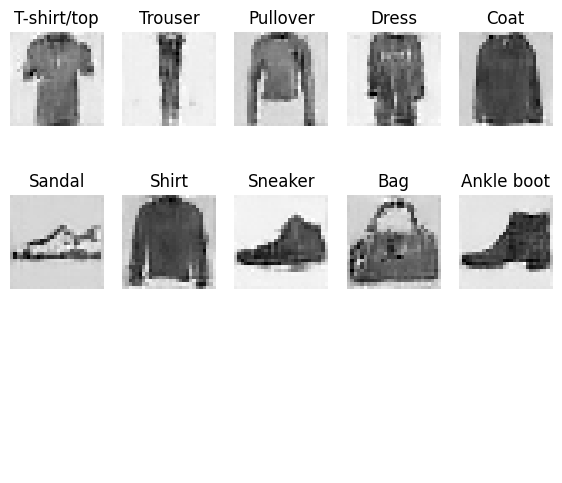

Epoch: 40, Losses: -0.010524903854727746, -6.118356671905517


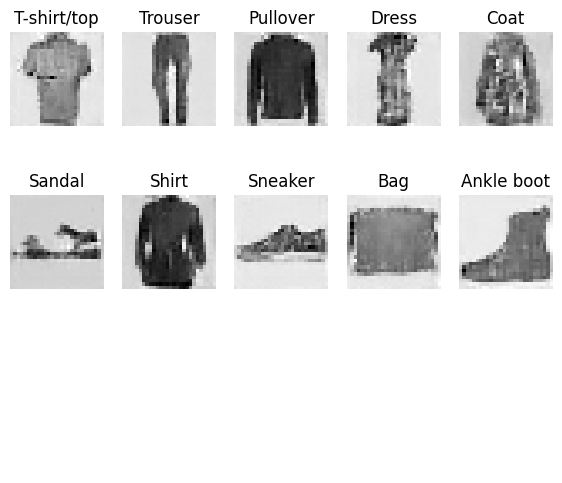

Epoch: 41, Losses: -0.009642268885175387, -6.052991065724691


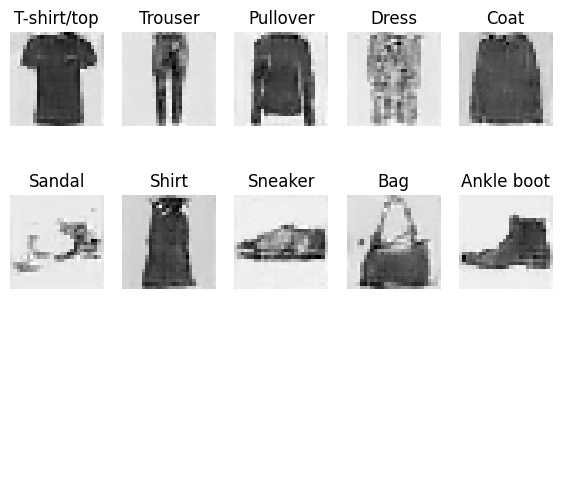

Epoch: 42, Losses: -0.0069495838627219204, -6.077795895131429


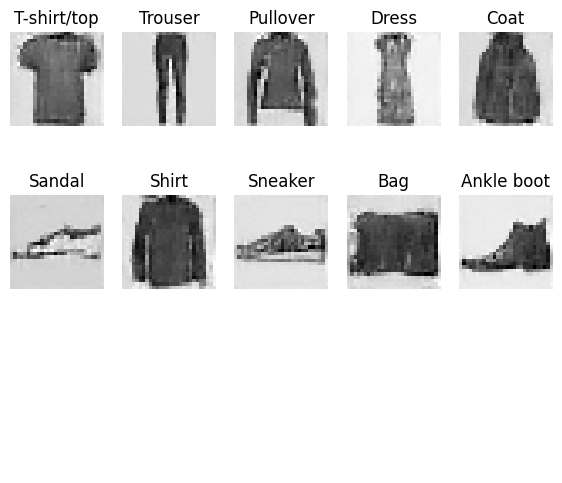

Epoch: 43, Losses: -0.004540315878391266, -6.097723298136393


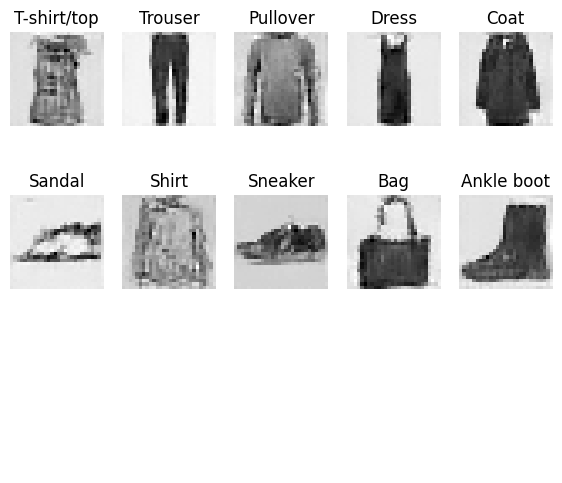

Epoch: 44, Losses: -0.005773037493725618, -6.140995881144206


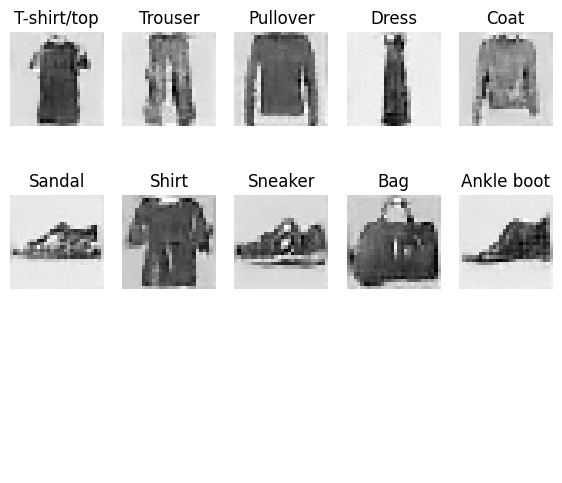

Epoch: 45, Losses: -0.002132854673763116, -6.053686367797852


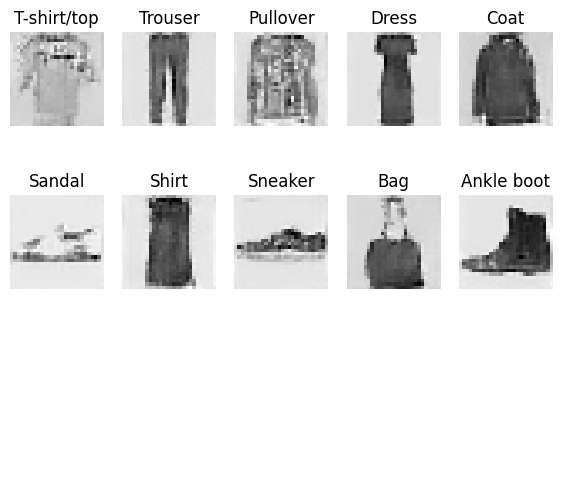

Epoch: 46, Losses: -0.002232161064942678, -6.039579262034098


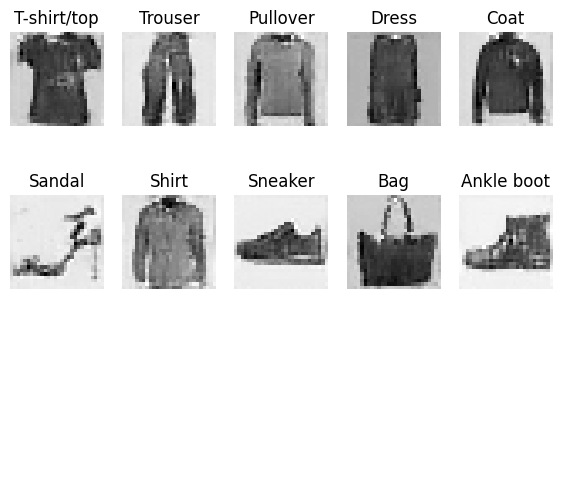

Epoch: 47, Losses: -0.002340486798187097, -5.981023508707683


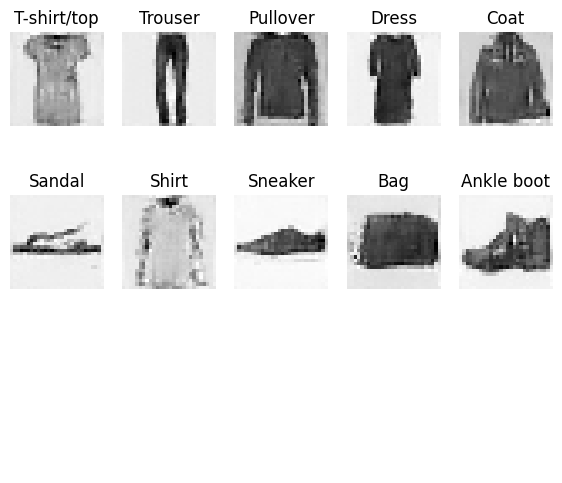

Epoch: 48, Losses: 7.840272784233093e-06, -5.888252878824869


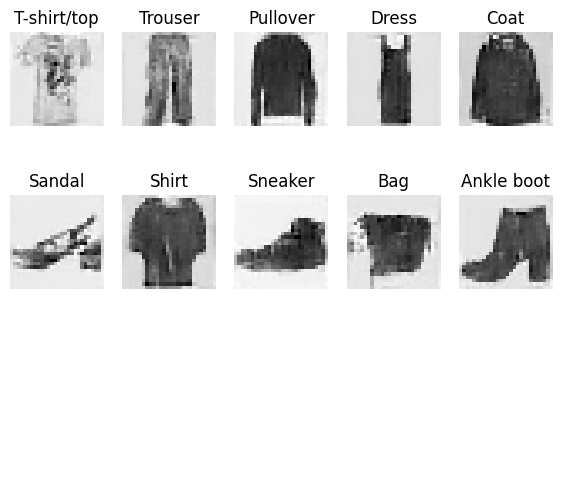

Epoch: 49, Losses: 0.0001842890421549479, -5.898189761098226


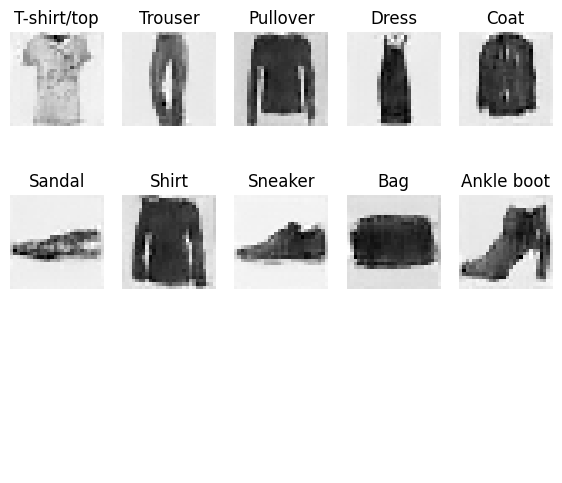

Epoch: 50, Losses: 0.0013329101969798405, -5.867063673909505


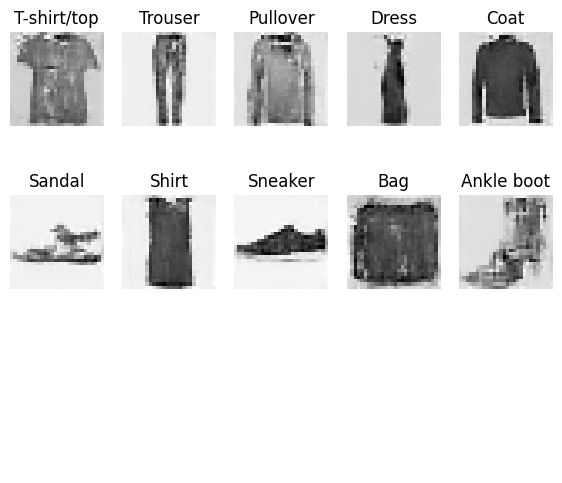

Epoch: 51, Losses: 0.0036057320440808934, -5.820625578308105


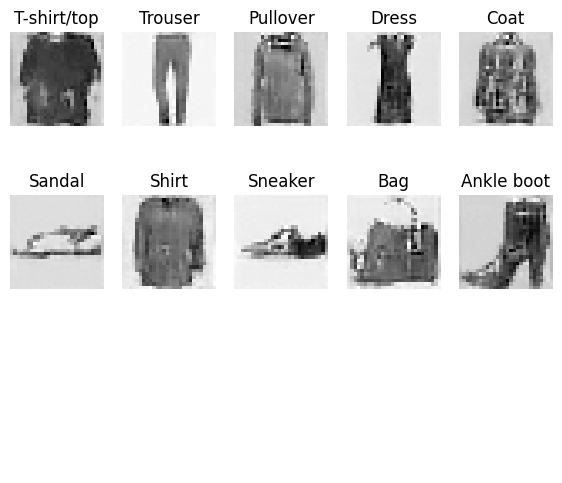

Epoch: 52, Losses: 0.0028753515740235647, -5.745837072499593


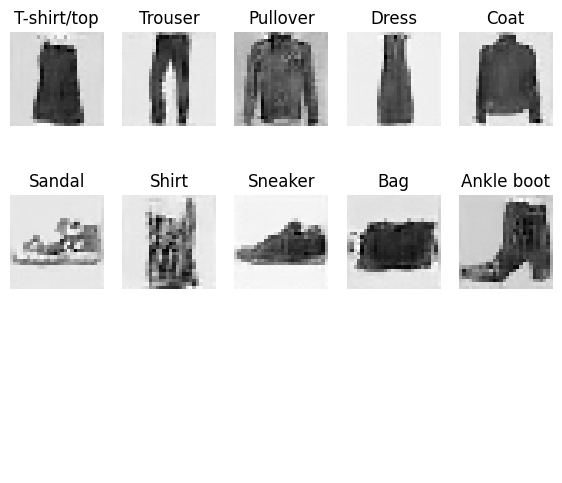

Epoch: 53, Losses: 0.003085477936764558, -5.711160683695475


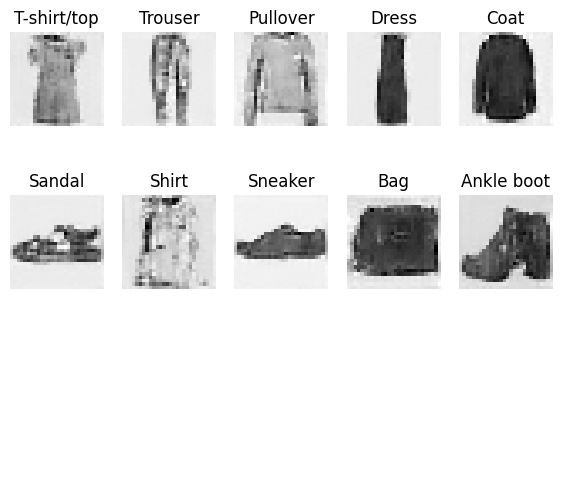

Epoch: 54, Losses: 0.005709814853966236, -5.606844308980306


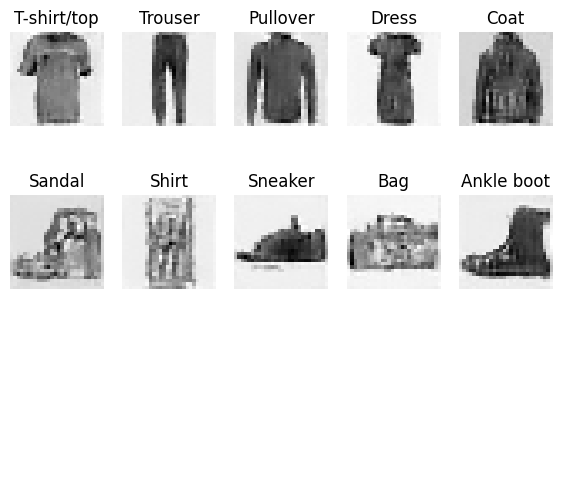

Epoch: 55, Losses: 0.0063745401086906595, -5.543130287679037


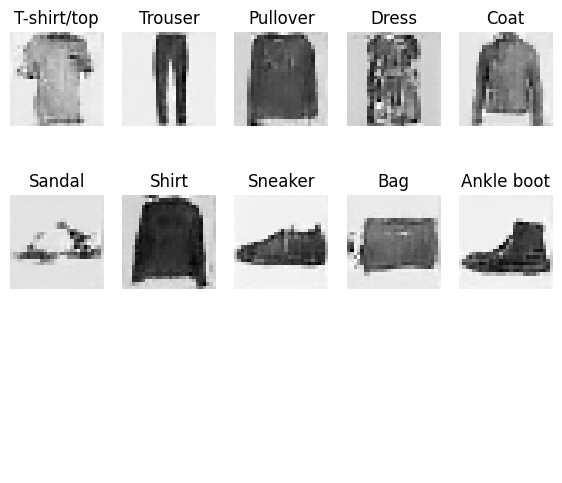

Epoch: 56, Losses: 0.006269713752965133, -5.558856709798177


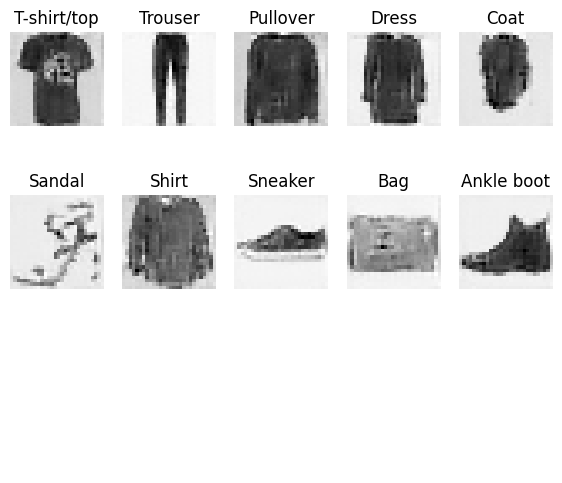

Epoch: 57, Losses: 0.0053090330749750135, -5.5160226636250815


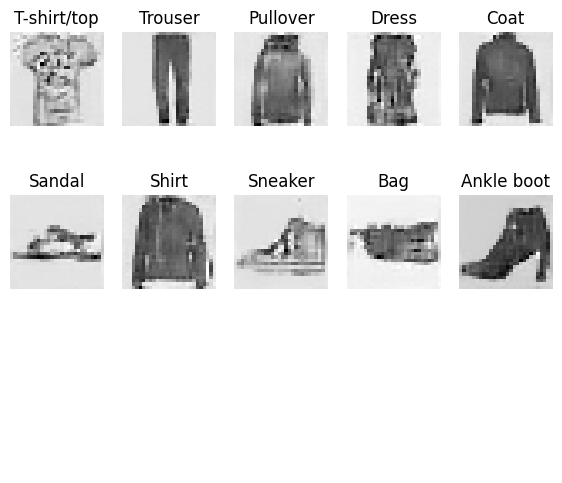

Epoch: 58, Losses: 0.006109098444133997, -5.476829453786214


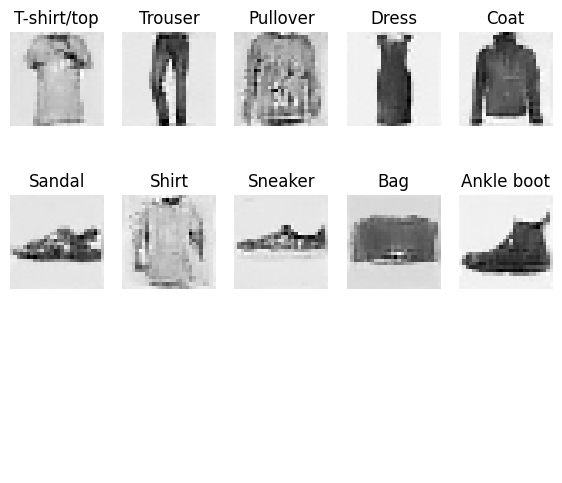

Epoch: 59, Losses: 0.0056636227803925675, -5.469906155904134


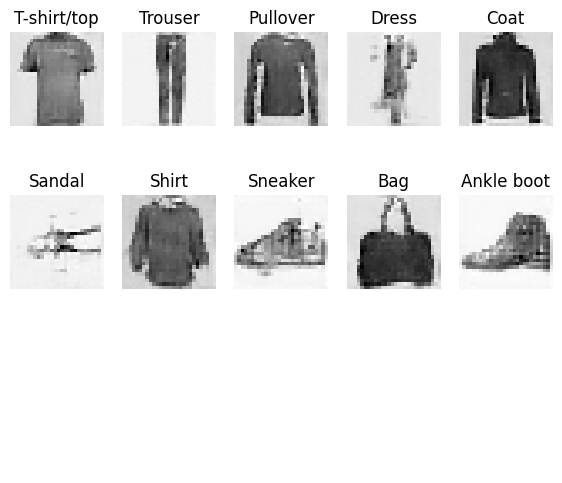

Epoch: 60, Losses: 0.005223693325867256, -5.425941365051269


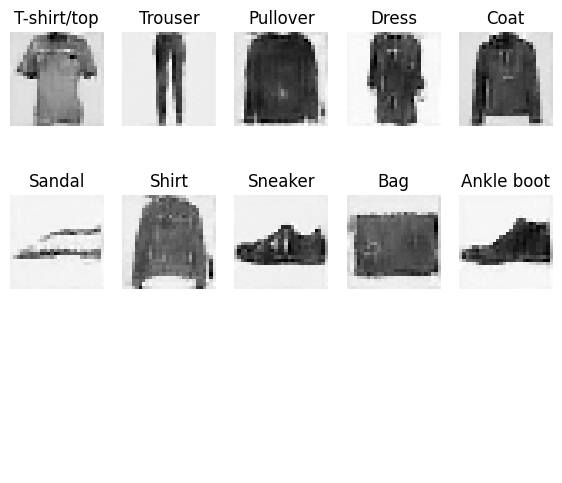

Epoch: 61, Losses: 0.00548763417378068, -5.398150435384115


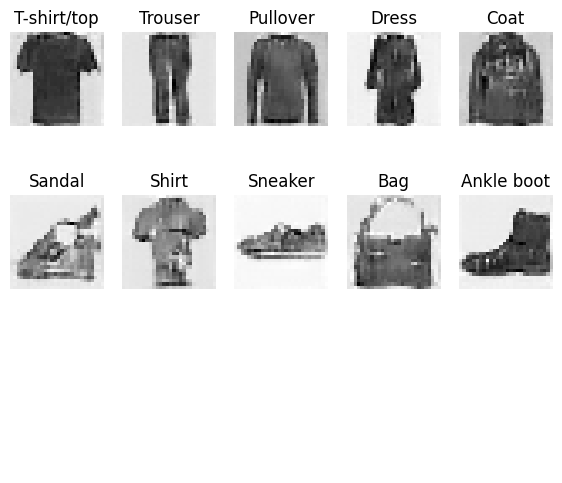

Epoch: 62, Losses: 0.005179664900402228, -5.315937331644694


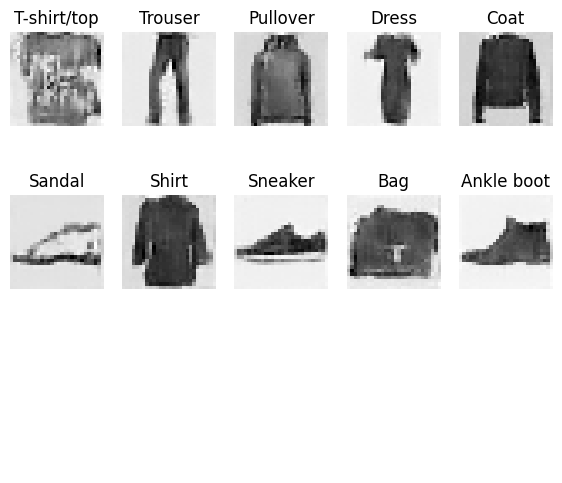

Epoch: 63, Losses: 0.005279631549119949, -5.266595766194661


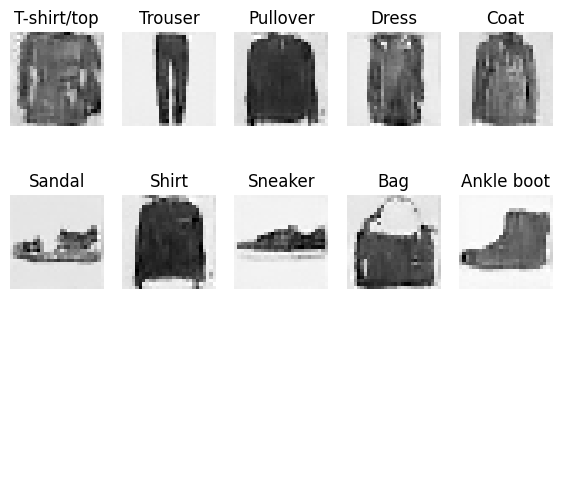

Epoch: 64, Losses: 0.006697787047922611, -5.201787858835856


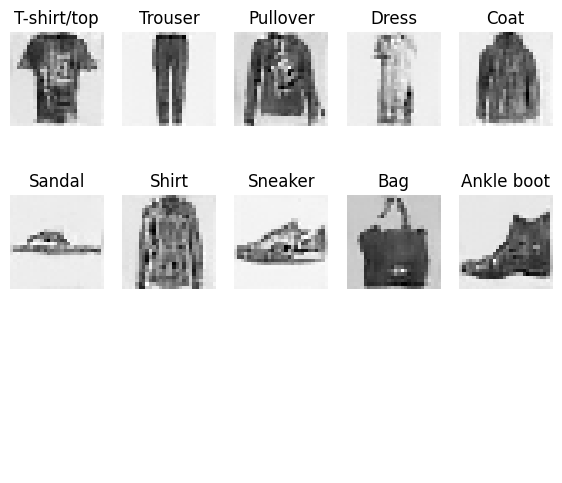

Epoch: 65, Losses: 0.008027082068721453, -5.246361857859293


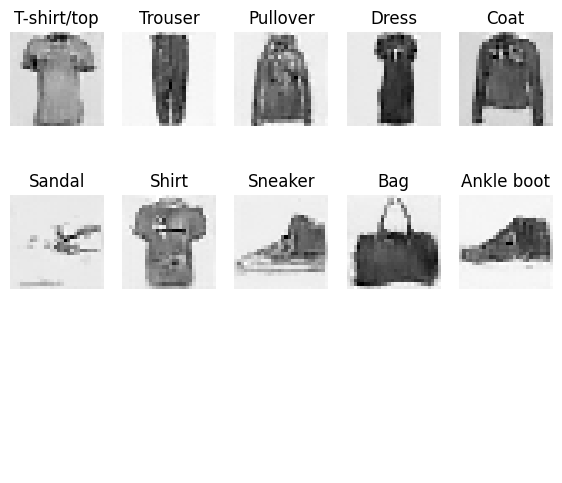

Epoch: 66, Losses: 0.008461727586636941, -5.205443256632487


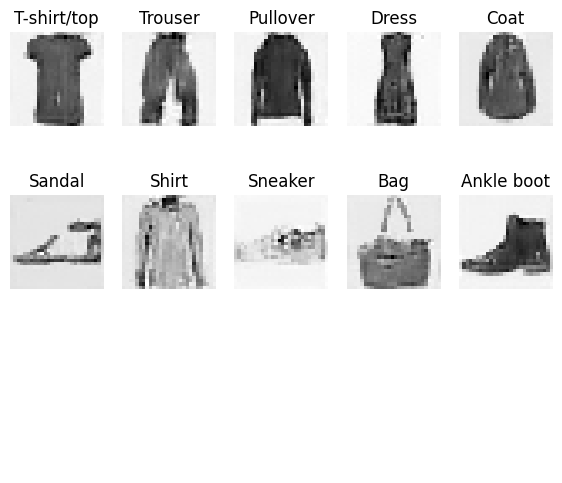

Epoch: 67, Losses: 0.006638980552057425, -5.22207039642334


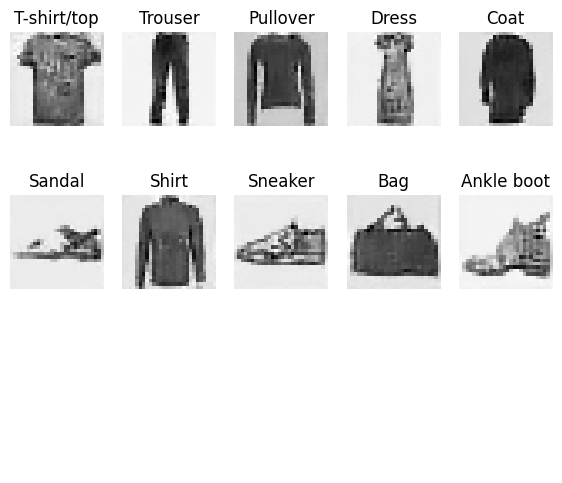

Epoch: 68, Losses: 0.006385253524531921, -5.205819081370036


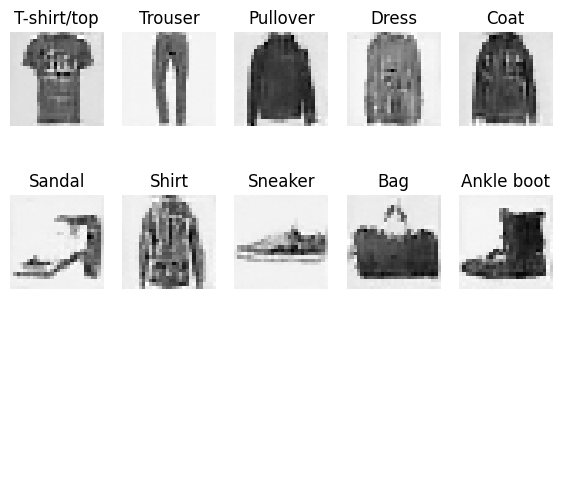

Epoch: 69, Losses: 0.0069167598662277065, -5.146063878122965


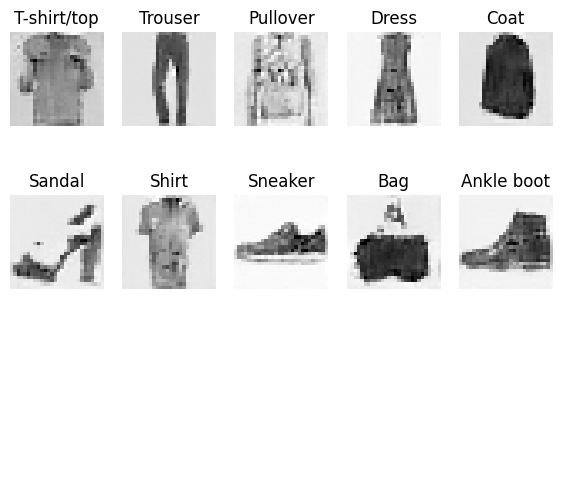

Epoch: 70, Losses: 0.005701758268475533, -5.100392255655924


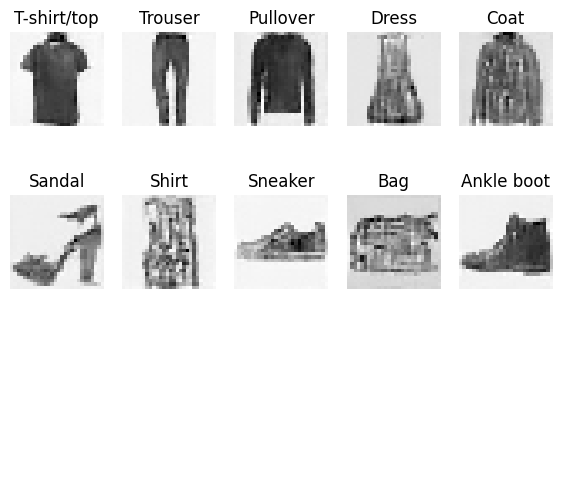

Epoch: 71, Losses: 0.006601679817090432, -5.030383673604329


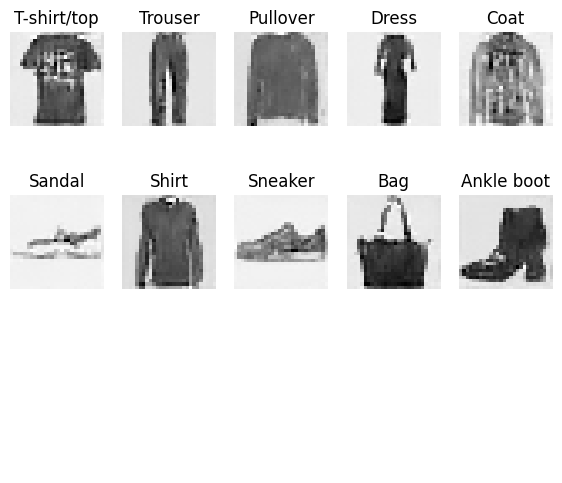

Epoch: 72, Losses: 0.006374986940373977, -5.013939408874512


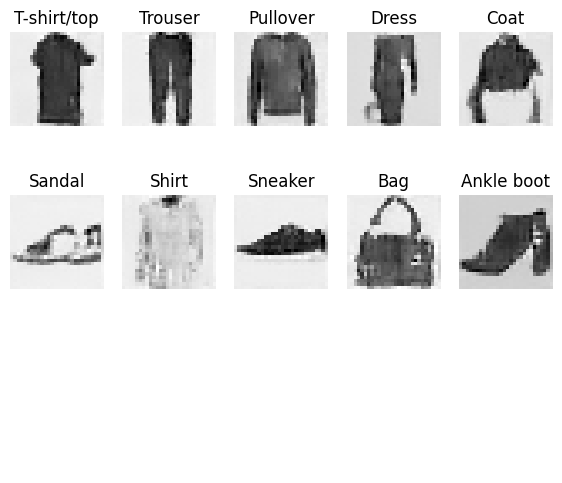

Epoch: 73, Losses: 0.005755229093506932, -4.983458951822917


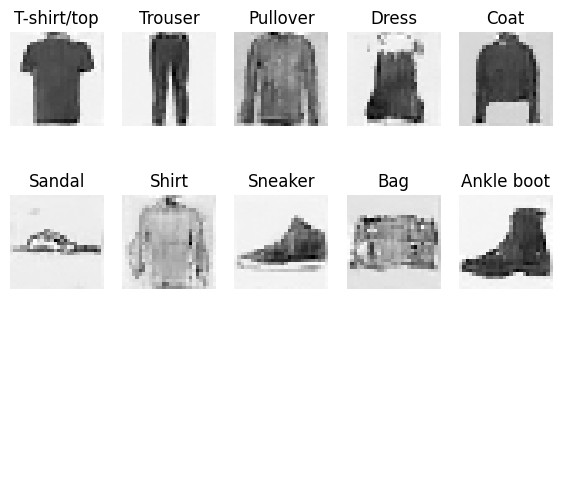

Epoch: 74, Losses: 0.005697453396270672, -4.952113660939535


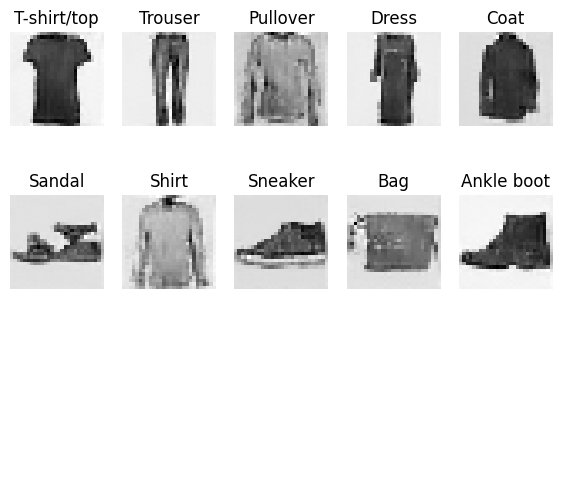

Epoch: 75, Losses: 0.006464319330702226, -4.886361751302084


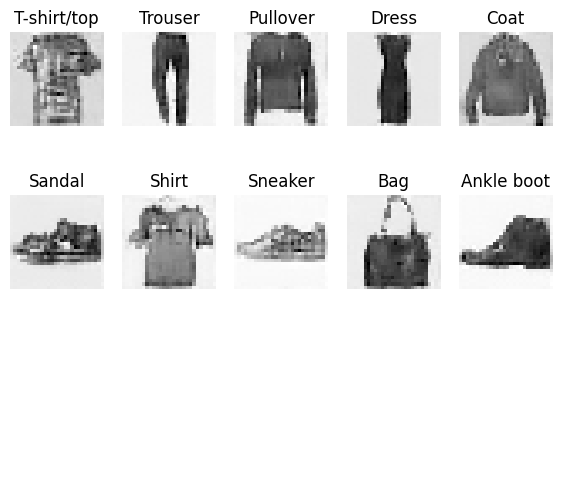

Epoch: 76, Losses: 0.007151379269858201, -4.810517168426514


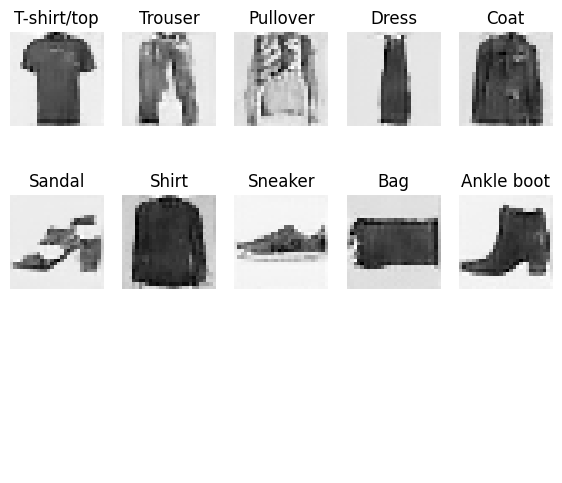

Epoch: 77, Losses: 0.007472101171066363, -4.782378345998128


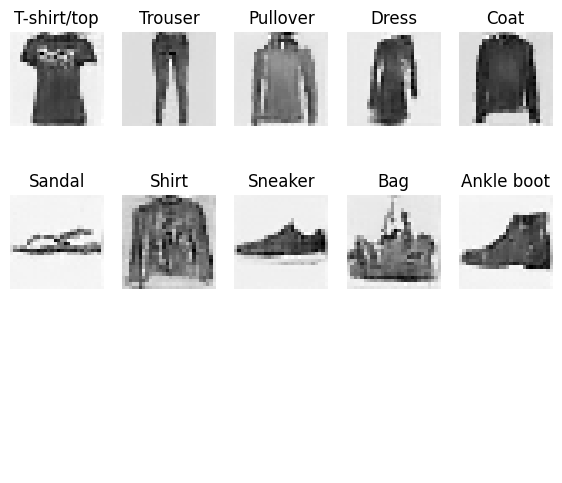

Epoch: 78, Losses: 0.00673635030562679, -4.739227184041341


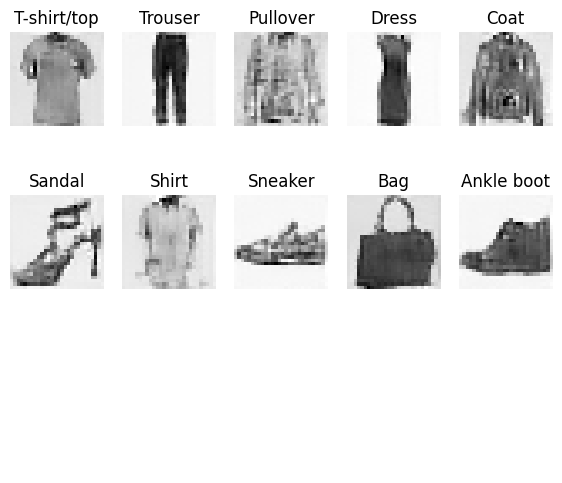

Epoch: 79, Losses: 0.006242234596113364, -4.674667287445068


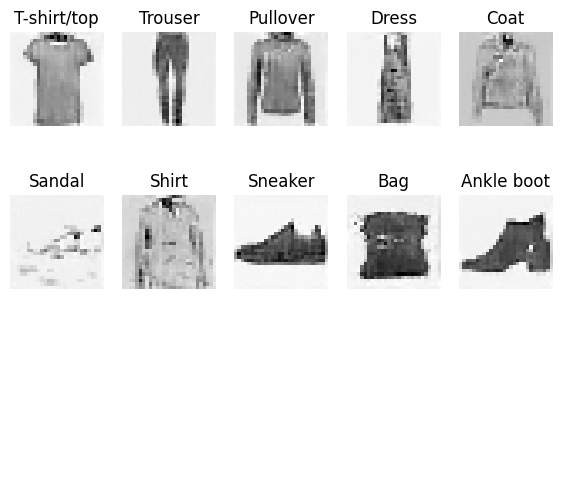

Epoch: 80, Losses: 0.008057889873286088, -4.677138999938965


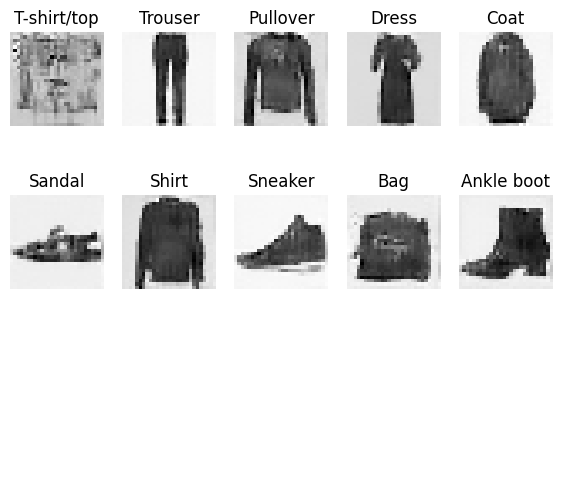

Epoch: 81, Losses: 0.006684801695495844, -4.653363853963216


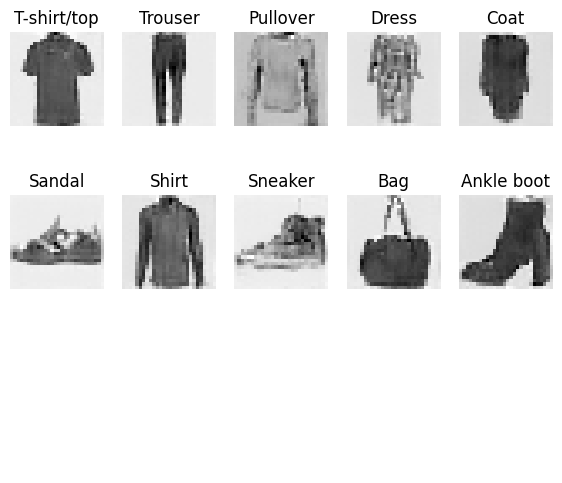

Epoch: 82, Losses: 0.0076311915134390194, -4.555356876373291


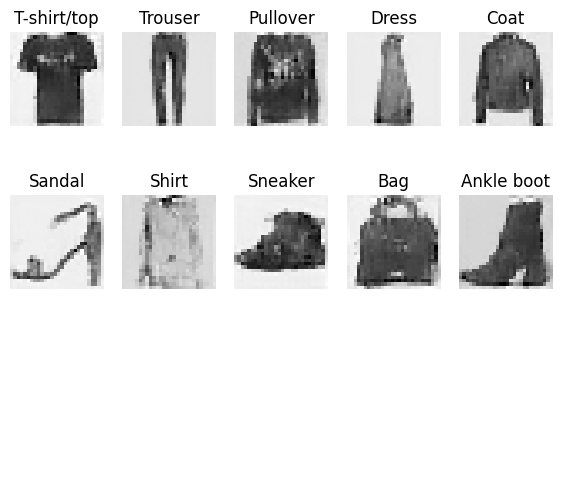

Epoch: 83, Losses: 0.007514376838753621, -4.55712785542806


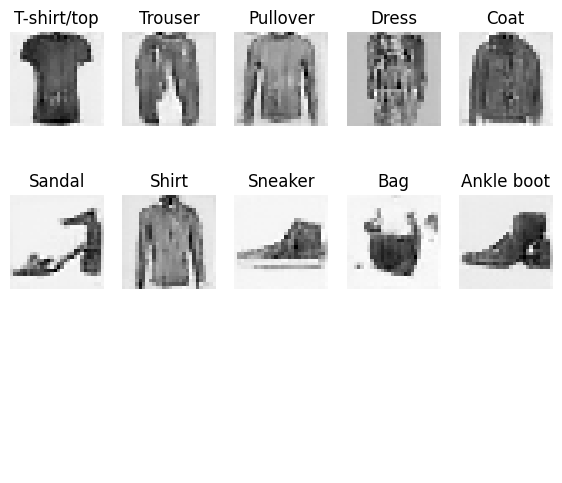

Epoch: 84, Losses: 0.007302608118454615, -4.575714624277751


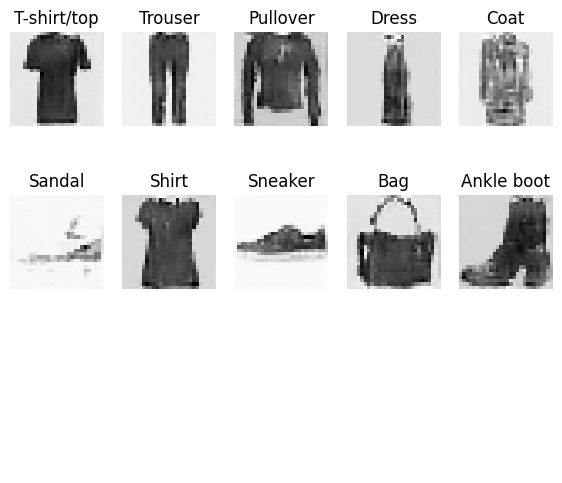

Epoch: 85, Losses: 0.007396989532311758, -4.500785753377278


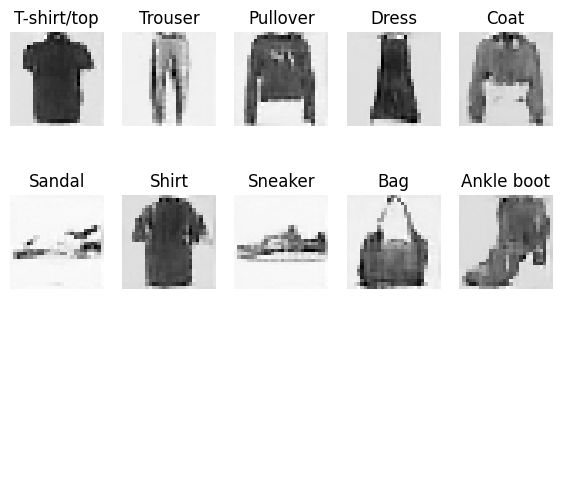

Epoch: 86, Losses: 0.0069527239844203, -4.447531958516439


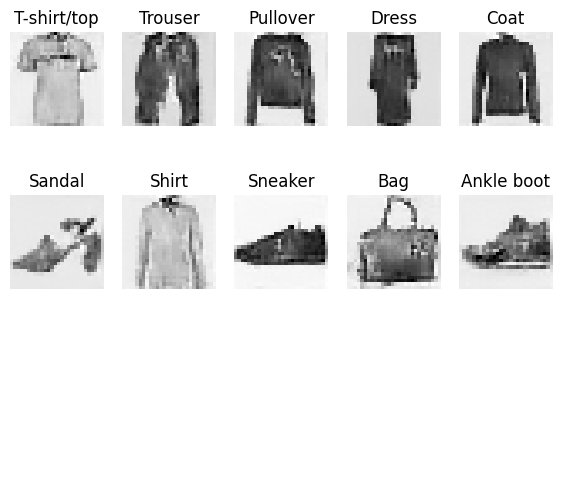

Epoch: 87, Losses: 0.007093673991660277, -4.422312520090739


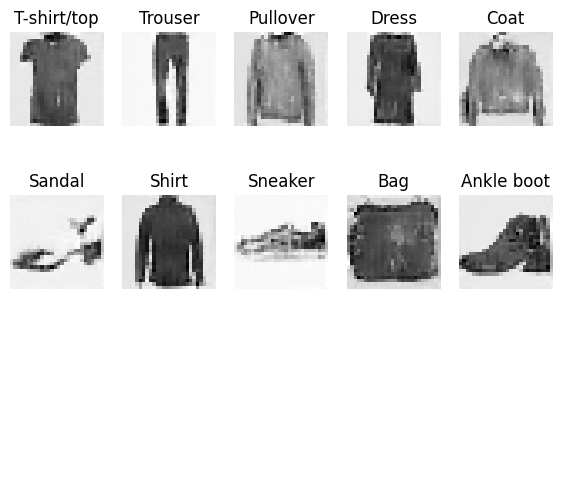

Epoch: 88, Losses: 0.006500989311064283, -4.339362806447347


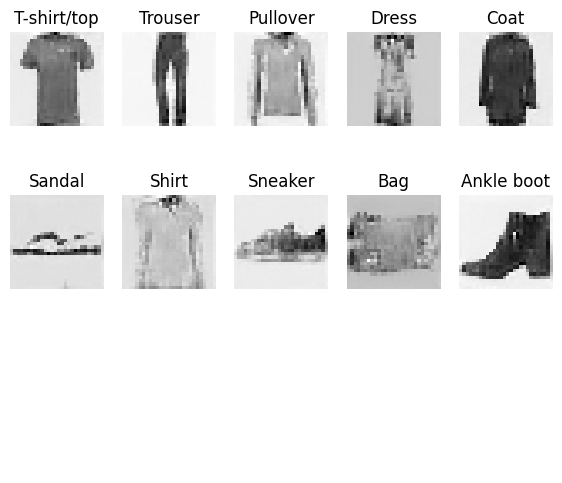

Epoch: 89, Losses: 0.00666701854125907, -4.376032120259603


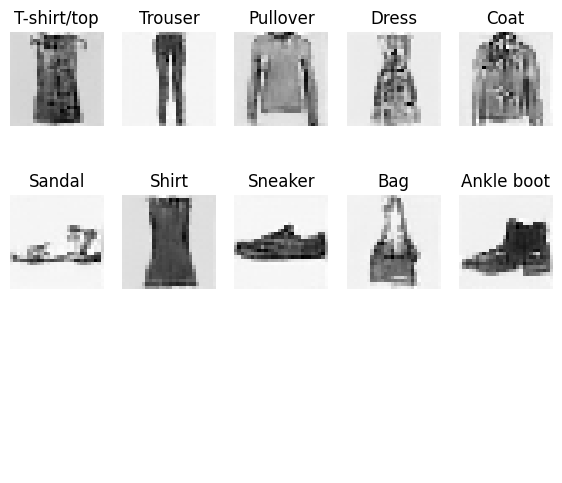

Epoch: 90, Losses: 0.007541996622209748, -4.32374740041097


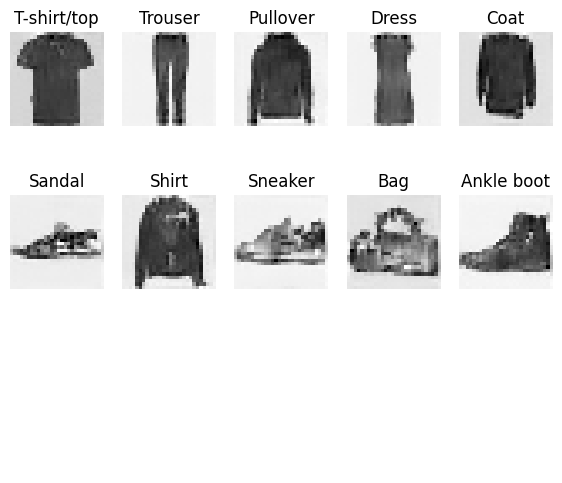

Epoch: 91, Losses: 0.0062441922008991246, -4.293363245137533


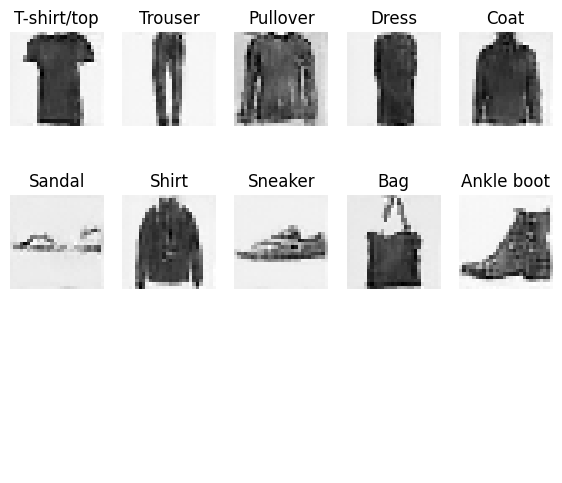

Epoch: 92, Losses: 0.0056640878645082314, -4.251310427093506


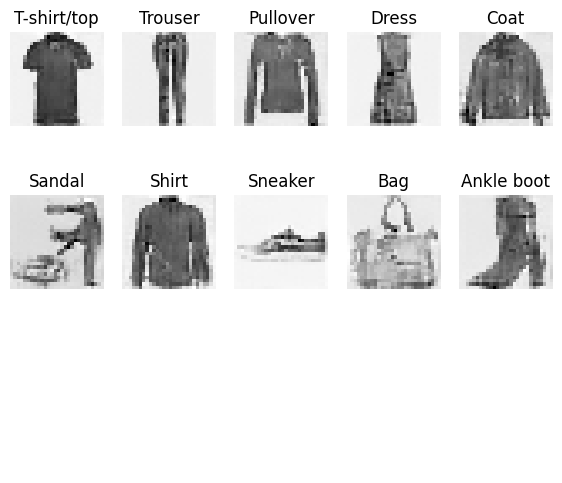

Epoch: 93, Losses: 0.005099247559905052, -4.226180094401042


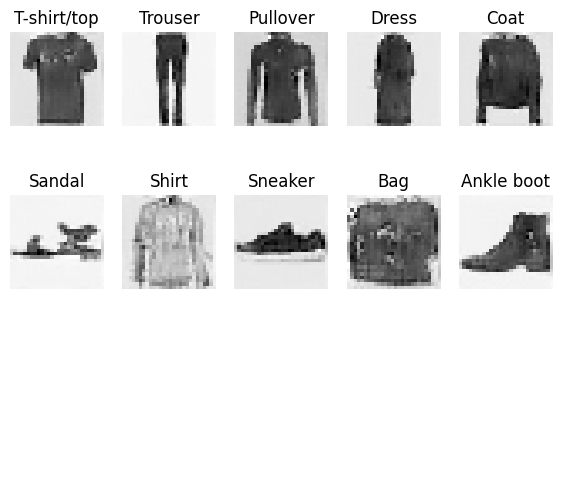

Epoch: 94, Losses: 0.004870020823429028, -4.209458559036255


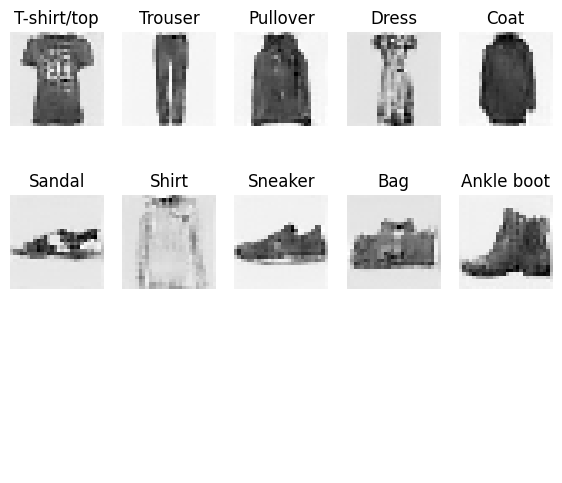

Epoch: 95, Losses: 0.005179860626161098, -4.129222114054362


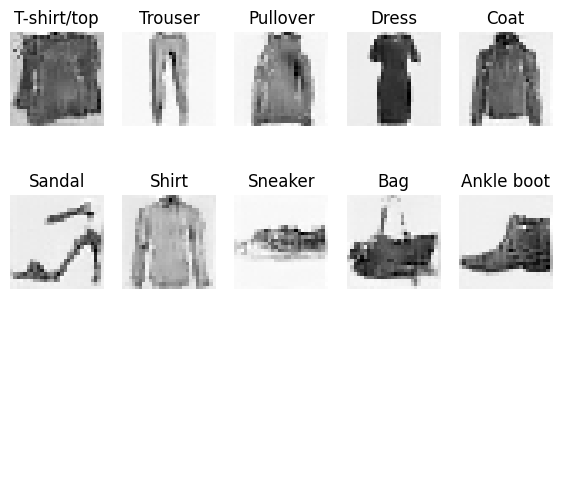

Epoch: 96, Losses: 0.005340774286786715, -4.0785754034678146


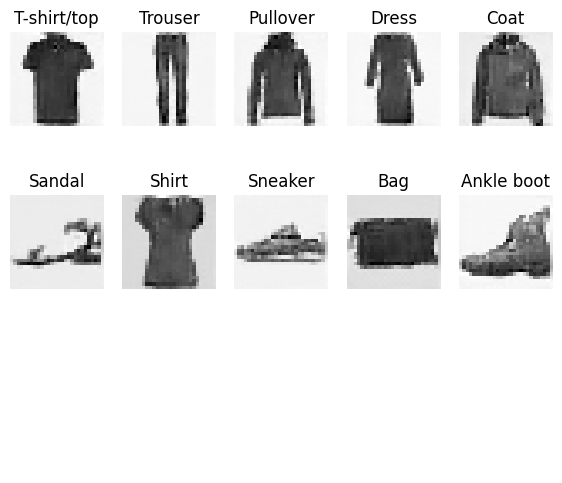

Epoch: 97, Losses: 0.004617039690166712, -4.083470378367106


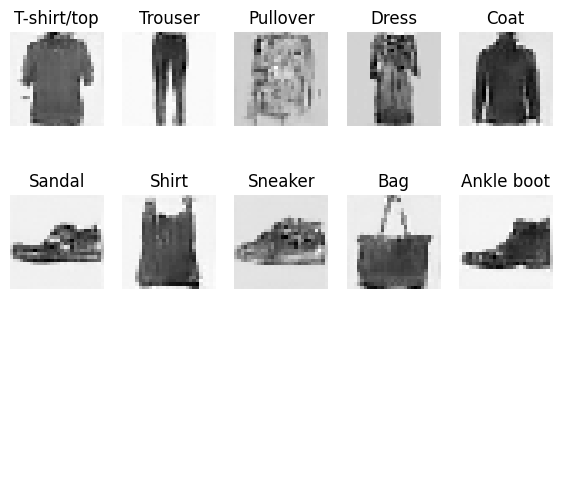

Epoch: 98, Losses: 0.0043753017567098144, -4.017506139628092


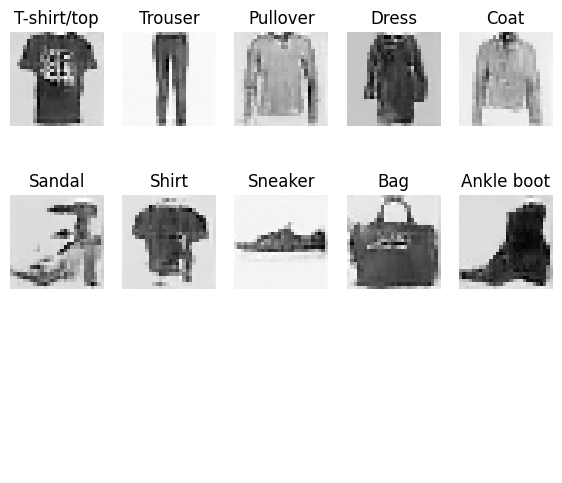

Epoch: 99, Losses: 0.004250512488683065, -3.9700753973642984


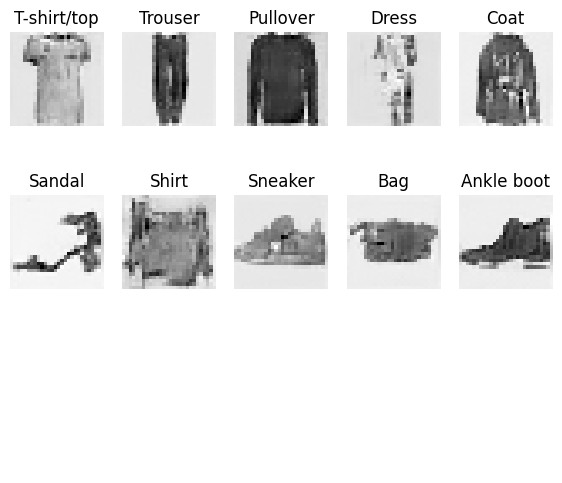

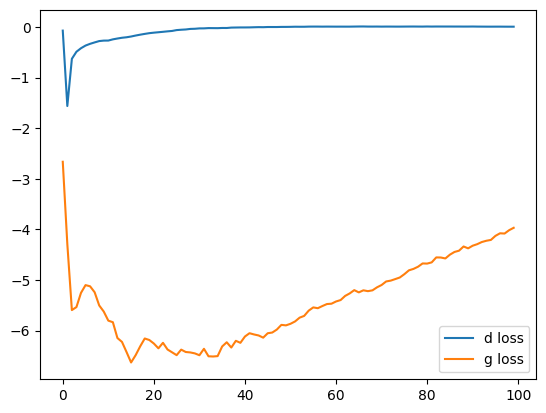

In [19]:
d_losses = []
g_losses = []

for e in range(n_epochs):
  d_loss_epoch = 0.
  g_loss_epoch = 0.

  for batch in train_loader:
    d_loss, g_loss = train_batch(
        d_model, g_model,
        d_optimizer, g_optimizer,
        batch,
        gen_dim=100, n_labels=10,
        device=device
    )
    d_loss_epoch += d_loss
    g_loss_epoch += g_loss

  d_loss_epoch /= len(train_loader)
  g_loss_epoch /= len(train_loader)
  print(f'Epoch: {e}, Losses: {d_loss_epoch}, {g_loss_epoch}')

  d_losses.append(d_loss_epoch)
  g_losses.append(g_loss_epoch)

  plot_generator(
      g_model,
      gen_dim=100, img_channels=1,
      idx_to_class=idx_to_class, n_labels=10,
      device=device, n_cols=5
  )

plt.plot(range(n_epochs), d_losses, label='d loss')
plt.plot(range(n_epochs), g_losses, label='g loss')
plt.legend()
plt.show()